In [1]:
from collections import defaultdict
from pathlib import Path
import json
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module py4j not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:36: UserWarning: Module distance not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/__init__.py:55: UserWarning: Module py4j not found. If you want to use these environments,
                    please follow the installation guide.
  warnings.warn(


In [2]:



TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

TASK2MaxReturn = {
    "classic_cartpole": 500,
    "dmc_walker": 1000
}

def get_expert_and_random_metrics():
    expert_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    random_agent_metrics = {
        "classic_cartpole": defaultdict(list),
        "dmc_walker": defaultdict(list)
    }
    specific_exp_dir = Path("../logs/specific")
    for exp_dir in specific_exp_dir.iterdir():

        expert_returns = []
        random_returns = []
        for seed_dir in exp_dir.iterdir():
            if (seed_dir / "eval.jsonl").exists():
                metrics = json.loads((seed_dir / "eval.jsonl").read_text().split("\n")[0])
                expert_returns.append(metrics["return"])
            if (seed_dir / "eval_random_policy.jsonl").exists():
                metrics = json.loads((seed_dir / "eval_random_policy.jsonl").read_text().split("\n")[0])
                random_returns.append(metrics["return"])
        if len(expert_returns) == 0:
            continue
        task = None
        for k in expert_agent_metrics:
            if k in exp_dir.name:
                task = k
                break
        
        ctx_0 = _TASK2CONTEXTS[task][0]["context"]
        ctx_1 = _TASK2CONTEXTS[task][1]["context"]
        env = _TASK2ENV[task]
        default_0 = env.get_default_context()[ctx_0]
        default_1 = env.get_default_context()[ctx_1]
        
        ctx_k_v_str = exp_dir.name.split("specific_")[1].split("_enc")[0]
        
        ctx_val = [default_0, default_1]
        for k_v in ctx_k_v_str.split("_"):
            k, v = k_v.split("-")
            v = float(v)
            k = int(k)
            ctx_val[int(k)] = v
        expert_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(expert_returns)
        random_agent_metrics[task][(ctx_val[0], ctx_val[1])] = np.max(random_returns)
    return expert_agent_metrics, random_agent_metrics

In [4]:
expert_agent_metrics, random_agent_metrics = get_expert_and_random_metrics()

In [5]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
tasks = ["classic_cartpole", "dmc_walker"]
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")


In [6]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from scipy.stats import sem

## RLiable Evals


In [7]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [8]:
#compute scores function 
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])

In [9]:
score_types = ["median", "IQM", "mean", "Optimality Gap"]

def compute_scs(score, target_metrics=["IQM",]):
    """
    
    """
    if score.shape[0] != 0:
        #aggregate using rliable
        score = score.transpose() #(num_runs, num_contexts)
        score = {"test": score}
        aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
            score, aggregate_func, reps=10000)
        #print(aggregate_scores, aggregate_score_cis)
        
        #print(aggregate_scores, aggregate_score_cis)
        aggregate_scores = {score_types[i]: aggregate_scores['test'][i] for i in range(len(score_types)) if score_types[i] in target_metrics}
        aggregate_score_cis = {score_types[i]: aggregate_score_cis['test'][:,i] for i in range(len(score_types)) if score_types[i] in target_metrics}
        return aggregate_scores, aggregate_score_cis
    return {key: None for key in target_metrics}, {key: None for key in target_metrics}

In [10]:
def match_and_normalize_metrics(agent_metrics, expert_metrics, random_metrics):
    normalized_metrics = {}
    min_ctx_0 = min([k[0] for k in agent_metrics])
    max_ctx_0 = max([k[0] for k in agent_metrics])
    min_ctx_1 = min([k[1] for k in agent_metrics])
    max_ctx_1 = max([k[1] for k in agent_metrics])
    normalized_best_keys = [
        ((k[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (k[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6)) for k in expert_metrics
    ]
    best_keys = list(expert_metrics.keys())
    
    for current_key, returns in agent_metrics.items():
        normalized_current_key = ((current_key[0] - min_ctx_0) / (max_ctx_0 - min_ctx_0 + 1e-6), (current_key[1] - min_ctx_1) / (max_ctx_1 - min_ctx_1 + 1e-6))
        distances = cdist([normalized_current_key], normalized_best_keys)
        nearest_index = np.argmin(distances)
        nearest_key = best_keys[nearest_index]
        nearest_best_return = expert_metrics[nearest_key]
        #print("returns shape:", returns.shape)
        #print(random_metrics[nearest_key])
        #print("random metrics shape:", len(random_metrics[current_key]))
        normalized_metrics[current_key] = (returns - random_metrics[nearest_key]) / (nearest_best_return - random_metrics[nearest_key])
    return normalized_metrics

In [11]:
def compute_summary_metric(log_dir, task, train_setting, context_idx, modality, ctx_type, best_agent_metrics, random_agent_metrics, t_step="50k", required_metrics=["IQM",]):
    assert train_setting in ["default", "single", "double_box"]
    assert train_setting != "double_box" or context_idx is None
    train_setting_full = train_setting
    metric_context_name = None
    if train_setting == "single":
        train_setting_full = f"{train_setting}_{context_idx}"
    if context_idx is not None:
        metric_context_name = _TASK2CONTEXTS[task][context_idx]["context"]

    
    if ctx_type == "no_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}"
        ctx_type = "no context"
    elif ctx_type == "enc_dec_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_ctx_dec_{modality}_ctx_{t_step}"
        ctx_type = "Concat Context"
    elif ctx_type == "pgm_ctx":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_{t_step}"
        ctx_type = "cRSSM"
    elif ctx_type == "pgm_ctx_adv":
        exp_path = log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_pgm_ctx_adv_{t_step}"
        ctx_type = "d-cRSSM"
    else:
        raise RuntimeError("invalid ctx")
    if not exp_path.exists():
        print("Path does not exist")
        return None

    modality = "featurized" if modality == "obs" else "pixel"
    ctx_0 = _TASK2CONTEXTS[task][0]["context"]
    ctx_1 = _TASK2CONTEXTS[task][1]["context"]
    env = _TASK2ENV[task]
    default_0 = env.get_default_context()[ctx_0]
    default_1 = env.get_default_context()[ctx_1]
    current_metrics = defaultdict(list)
    for seed_path in exp_path.iterdir():
        eval_file = seed_path / "eval.jsonl"
        if not eval_file.exists():
            continue
        with eval_file.open() as f:
            lines = f.readlines()
        lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
        if len(lines) != 84:
            continue
        for line in lines:
            ctx_0_val, ctx_1_val = line['ctx']["context"][ctx_0], line['ctx']["context"][ctx_1]
            ret = float(line['return'])
            if train_setting == "double_box" or (train_setting == "default" and context_idx is None)  or (metric_context_name in line["ctx"]["changed"] and len(line["ctx"]["changed"]) == 1 or len(line["ctx"]["changed"]) == 0):
                current_metrics[(ctx_0_val, ctx_1_val)].append(ret)
    agent_metrics = {k: np.array(v) for k, v in current_metrics.items()}
    normalized_score = {}
    best_metrics = best_agent_metrics[task]
    random_metrics = random_agent_metrics[task]
    normalized_score = match_and_normalize_metrics(agent_metrics, best_metrics, random_metrics)
    #print(normalized_score)
    interpolate_ranges = [
        [default_0 - 1e-6, default_0 + 1e-6],
        [default_1 - 1e-6, default_1 + 1e-6]
    ]
    if context_idx is not None:
        interpolate_ranges[context_idx] = _TASK2CONTEXTS[task][context_idx]["train_range"]
    else:
        interpolate_ranges[0] = _TASK2CONTEXTS[task][0]["train_range"]
        interpolate_ranges[1] = _TASK2CONTEXTS[task][1]["train_range"]
    
    
    interpolate_score = []
    extrapolate_score = []
    inter_extrapolate_score = []
    
    for ctx_key in normalized_score:
        if (ctx_key[0] >= interpolate_ranges[0][0] and ctx_key[0] <= interpolate_ranges[0][1]) and (ctx_key[1] >= interpolate_ranges[1][0] and ctx_key[1] <= interpolate_ranges[1][1]):
            if normalized_score:
                interpolate_score.append(normalized_score[ctx_key])
 
        elif context_idx is not None or (ctx_key[0] < interpolate_ranges[0][0] or ctx_key[0] > interpolate_ranges[0][1]) and (ctx_key[1] < interpolate_ranges[1][0] or ctx_key[1] > interpolate_ranges[1][1]):
            if normalized_score:
                extrapolate_score.append(normalized_score[ctx_key])

        else:
            if normalized_score:
                inter_extrapolate_score.append(normalized_score[ctx_key])

    interpolate_score = np.array(interpolate_score)
    extrapolate_score = np.array(extrapolate_score)
    inter_extrapolate_score = np.array(inter_extrapolate_score)

    #use compute_scs to aggregate
    interpolate_score, interpolate_cis = compute_scs(interpolate_score, required_metrics) 
    extrapolate_score, extrapolate_cis = compute_scs(extrapolate_score, required_metrics)
    inter_extrapolate_score, inter_extra_cis = compute_scs(inter_extrapolate_score, required_metrics)
    print(inter_extra_cis)
    if task == "classic_cartpole":
        task = "Cartpole"
    elif task == "dmc_walker":
        task = "dmc Walker"
    return {'Task':task,
            'Train Setting':train_setting,
            'Context':metric_context_name or f'{ctx_0},{ctx_1}',
            'Modality':modality,
            'Inputs': ctx_type,
            **{f'Interp_{key}' : round(val,3) if val is not None else val for key, val in interpolate_score.items() },
            **{f'Extrap_{key}' : round(val,3) if val is not None else val for key, val in extrapolate_score.items()},
            **{f'Inter_Extra_{key}' : round(val,3) if val is not None else val for key, val in inter_extrapolate_score.items()},
            **{f'Interp_{key}_ci' : np.round(val,3) if val is not None else val for key, val in interpolate_cis.items()},
            **{f'Extrap_{key}_ci' :  np.round(val,3) if val is not None else val for key, val in extrapolate_cis.items()},
            **{f'Inter_Extra_{key}_ci' : np.round(val,3) if val is not None else val for key, val in inter_extra_cis.items()},
    }
    

In [12]:
tasks = ["classic_cartpole", "dmc_walker"]
train_settings = ["default", "single", "double_box"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
score_names = ["i_score", "e_score", "ie_score"]
logdir = Path("../logs")
save_dir = Path("./plots/")
best = 8

required_metrics = ["IQM", "Optimality Gap", "mean", "median"]
df_list = []
import warnings
for task in tasks:
    for setting in ["single", "double_box"]:
        if setting == "single":
            context_ids = [0, 1]
        else:
            context_ids = [None]
        for ctx_id in context_ids:
            for modality in modalities:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    row = compute_summary_metric(logdir, task, "default", ctx_id, modality, "no_ctx", expert_agent_metrics, random_agent_metrics, "normalized", required_metrics)
                    #if row:
                    # row_details, scores = row[:-3], row[-3:]
                    # #loop over returned scores and add to df
                    # scores = tuple([compute_scs(score) for score in scores])
                    # print("scores are:", scores)
                    #df.loc[len(df)] = row #row_details + scores
                    df_list.append(row)
                    for ctx_type in ["no_ctx", "enc_dec_ctx", "pgm_ctx", "pgm_ctx_adv"]:
                        row = compute_summary_metric(logdir, task, setting, ctx_id, modality, ctx_type, expert_agent_metrics, random_agent_metrics, "normalized", required_metrics)
                        # row_details, scores = row[:-3], row[-3:]
                        # scores = tuple([compute_scs(score) for score in scores])
                        #df.loc[len(df)] = row #row_details + scores
                        df_list.append(row)

{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': None, 'median': None}
{'IQM': None, 'Optimality Gap': None, 'mean': No

In [13]:
df = pd.DataFrame(df_list)
df

,Task,Train Setting,Context,Modality,Inputs,Interp_median,Interp_IQM,Interp_mean,Interp_Optimality Gap,Extrap_median,...,Interp_mean_ci,Interp_Optimality Gap_ci,Extrap_median_ci,Extrap_IQM_ci,Extrap_mean_ci,Extrap_Optimality Gap_ci,Inter_Extra_IQM_ci,Inter_Extra_Optimality Gap_ci,Inter_Extra_mean_ci,Inter_Extra_median_ci
0,Cartpole,default,gravity,featurized,no context,0.998,1.000,0.998,0.002,0.998,...,"[0.997, 1.0]","[0.0, 0.003]","[0.996, 1.0]","[1.0, 1.0]","[0.992, 0.998]","[0.002, 0.008]",None,None,None,None
1,Cartpole,single,gravity,featurized,no context,0.999,1.000,0.998,0.002,0.994,...,"[0.994, 1.0]","[0.0, 0.006]","[0.99, 1.0]","[1.0, 1.0]","[0.968, 0.995]","[0.005, 0.032]",None,None,None,None
2,Cartpole,single,gravity,featurized,Concat Context,0.999,1.000,0.998,0.002,0.982,...,"[0.996, 1.0]","[0.0, 0.004]","[0.974, 0.998]","[1.0, 1.0]","[0.964, 0.99]","[0.01, 0.036]",None,None,None,None
3,Cartpole,single,gravity,featurized,cRSSM,0.981,1.000,0.979,0.021,0.974,...,"[0.963, 0.992]","[0.008, 0.037]","[0.965, 0.997]","[0.999, 1.0]","[0.952, 0.986]","[0.014, 0.048]",None,None,None,None
4,Cartpole,single,gravity,featurized,d-cRSSM,0.972,1.000,0.972,0.028,0.978,...,"[0.951, 0.99]","[0.01, 0.049]","[0.973, 0.995]","[0.999, 1.0]","[0.972, 0.99]","[0.01, 0.028]",None,None,None,None
5,Cartpole,default,gravity,pixel,no context,0.998,1.000,0.987,0.013,0.949,...,"[0.977, 0.995]","[0.005, 0.023]","[0.918, 0.974]","[0.908, 0.962]","[0.785, 0.845]","[0.155, 0.215]",None,None,None,None
6,Cartpole,single,gravity,pixel,no context,0.999,1.000,0.998,0.002,0.992,...,"[0.996, 0.999]","[0.001, 0.004]","[0.986, 0.997]","[0.991, 0.998]","[0.953, 0.977]","[0.023, 0.047]",None,None,None,None
7,Cartpole,single,gravity,pixel,Concat Context,0.999,1.000,0.998,0.002,0.993,...,"[0.997, 1.0]","[0.0, 0.003]","[0.988, 0.997]","[0.995, 0.999]","[0.986, 0.993]","[0.007, 0.014]",None,None,None,None
8,Cartpole,single,gravity,pixel,cRSSM,1.000,1.000,1.000,0.000,0.995,...,"[1.0, 1.0]","[0.0, 0.0]","[0.993, 0.998]","[0.998, 1.0]","[0.992, 0.996]","[0.004, 0.008]",None,None,None,None
9,Cartpole,single,gravity,pixel,d-cRSSM,0.999,1.000,0.998,0.002,0.995,...,"[0.997, 1.0]","[0.0, 0.003]","[0.992, 0.999]","[0.999, 1.0]","[0.981, 0.995]","[0.005, 0.019]",None,None,None,None


In [14]:
#save df
df.to_csv("summary_metrics_final_x.csv")

In [15]:
#load csv "summary_metrics_final_x.csv"
df = pd.read_csv("summary_metrics_final_x.csv", index_col=0)

## Plot of the RLiable Evals

In [16]:
print(df.head()['Inputs'].unique())

['no context' 'Concat Context' 'cRSSM' 'd-cRSSM']


In [17]:
df.loc[df['Train Setting']=='default', 'Inputs'] = df.loc[df['Train Setting']=='default', 'Inputs'] + ' (default)'

In [18]:
df

,Task,Train Setting,Context,Modality,Inputs,Interp_median,Interp_IQM,Interp_mean,Interp_Optimality Gap,Extrap_median,...,Interp_mean_ci,Interp_Optimality Gap_ci,Extrap_median_ci,Extrap_IQM_ci,Extrap_mean_ci,Extrap_Optimality Gap_ci,Inter_Extra_IQM_ci,Inter_Extra_Optimality Gap_ci,Inter_Extra_mean_ci,Inter_Extra_median_ci
0,Cartpole,default,gravity,featurized,no context (default),0.998,1.000,0.998,0.002,0.998,...,[0.997 1. ],[0. 0.003],[0.996 1. ],[1. 1.],[0.992 0.998],[0.002 0.008],NaN,NaN,NaN,NaN
1,Cartpole,single,gravity,featurized,no context,0.999,1.000,0.998,0.002,0.994,...,[0.994 1. ],[0. 0.006],[0.99 1. ],[1. 1.],[0.968 0.995],[0.005 0.032],NaN,NaN,NaN,NaN
2,Cartpole,single,gravity,featurized,Concat Context,0.999,1.000,0.998,0.002,0.982,...,[0.996 1. ],[0. 0.004],[0.974 0.998],[1. 1.],[0.964 0.99 ],[0.01 0.036],NaN,NaN,NaN,NaN
3,Cartpole,single,gravity,featurized,cRSSM,0.981,1.000,0.979,0.021,0.974,...,[0.963 0.992],[0.008 0.037],[0.965 0.997],[0.999 1. ],[0.952 0.986],[0.014 0.048],NaN,NaN,NaN,NaN
4,Cartpole,single,gravity,featurized,d-cRSSM,0.972,1.000,0.972,0.028,0.978,...,[0.951 0.99 ],[0.01 0.049],[0.973 0.995],[0.999 1. ],[0.972 0.99 ],[0.01 0.028],NaN,NaN,NaN,NaN
5,Cartpole,default,gravity,pixel,no context (default),0.998,1.000,0.987,0.013,0.949,...,[0.977 0.995],[0.005 0.023],[0.918 0.974],[0.908 0.962],[0.785 0.845],[0.155 0.215],NaN,NaN,NaN,NaN
6,Cartpole,single,gravity,pixel,no context,0.999,1.000,0.998,0.002,0.992,...,[0.996 0.999],[0.001 0.004],[0.986 0.997],[0.991 0.998],[0.953 0.977],[0.023 0.047],NaN,NaN,NaN,NaN
7,Cartpole,single,gravity,pixel,Concat Context,0.999,1.000,0.998,0.002,0.993,...,[0.997 1. ],[0. 0.003],[0.988 0.997],[0.995 0.999],[0.986 0.993],[0.007 0.014],NaN,NaN,NaN,NaN
8,Cartpole,single,gravity,pixel,cRSSM,1.000,1.000,1.000,0.000,0.995,...,[1. 1.],[0. 0.],[0.993 0.998],[0.998 1. ],[0.992 0.996],[0.004 0.008],NaN,NaN,NaN,NaN
9,Cartpole,single,gravity,pixel,d-cRSSM,0.999,1.000,0.998,0.002,0.995,...,[0.997 1. ],[0. 0.003],[0.992 0.999],[0.999 1. ],[0.981 0.995],[0.005 0.019],NaN,NaN,NaN,NaN


In [19]:
#rename inter_extra to Inter_Extra in all columns
df.columns = df.columns.str.replace('inter_extra', 'Inter_Extra')

In [20]:
df_small= df[-5:]

In [21]:
df_small.shape


(5, 29)

In [22]:
df_small

,Task,Train Setting,Context,Modality,Inputs,Interp_median,Interp_IQM,Interp_mean,Interp_Optimality Gap,Extrap_median,...,Interp_mean_ci,Interp_Optimality Gap_ci,Extrap_median_ci,Extrap_IQM_ci,Extrap_mean_ci,Extrap_Optimality Gap_ci,Inter_Extra_IQM_ci,Inter_Extra_Optimality Gap_ci,Inter_Extra_mean_ci,Inter_Extra_median_ci
55,dmc Walker,default,"gravity,actuator_strength",pixel,no context (default),0.583,0.574,0.633,0.417,0.344,...,[0.598 0.671],[0.393 0.441],[0.315 0.364],[0.308 0.343],[0.313 0.34 ],[0.66 0.687],[0.357 0.388],[0.628 0.665],[0.337 0.381],[0.353 0.405]
56,dmc Walker,double_box,"gravity,actuator_strength",pixel,no context,0.667,0.649,0.811,0.333,0.413,...,[0.747 0.874],[0.306 0.36 ],[0.396 0.43 ],[0.383 0.409],[0.359 0.386],[0.614 0.641],[0.455 0.483],[0.541 0.577],[0.445 0.496],[0.458 0.516]
57,dmc Walker,double_box,"gravity,actuator_strength",pixel,Concat Context,0.653,0.658,0.860,0.314,0.418,...,[0.802 0.919],[0.294 0.333],[0.397 0.438],[0.393 0.42 ],[0.359 0.381],[0.619 0.641],[0.482 0.507],[0.521 0.56 ],[0.469 0.521],[0.48 0.534]
58,dmc Walker,double_box,"gravity,actuator_strength",pixel,cRSSM,0.613,0.606,0.774,0.353,0.344,...,[0.726 0.827],[0.329 0.377],[0.317 0.362],[0.319 0.346],[0.299 0.323],[0.677 0.701],[0.41 0.437],[0.571 0.607],[0.404 0.449],[0.419 0.473]
59,dmc Walker,double_box,"gravity,actuator_strength",pixel,d-cRSSM,0.643,0.666,0.887,0.320,0.458,...,[0.814 0.96 ],[0.291 0.35 ],[0.427 0.471],[0.382 0.416],[0.338 0.366],[0.634 0.662],[0.483 0.521],[0.518 0.569],[0.47 0.541],[0.498 0.555]


In [23]:
def convert_to_lst(s):
    s = s.strip('[]')  # Remove the brackets
    list_num = list(map(float, s.split()))
    return list_num

In [24]:
import os
def compare_plot_algorithms(df):
    metrics = ['median', 'IQM', 'mean', 'Optimality Gap']
    types = ['Interp', 'Extrap', 'Inter_Extra']
    aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
    algorithms = df['Inputs'].unique()
    #get task from the first row and column Task 
    task = df['Task'].values[0]
    train_settings = df['Train Setting'].values[-1]
    Context	= df['Context'].values[0]
    modality = df['Modality'].values[0]
    
    for type in types:
        aggregate_scores, aggregate_score_cis = defaultdict(list), defaultdict(list)
        for algorithm in algorithms:
            for i in range(len(metrics)):
                val = df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}'].values[0]
                #check if val is NaN
                if val != val:
                    #print('skipping')
                    continue
                #print(df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}_ci'].shape)
                aggregate_scores[algorithm].append(df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}'].values[0])
                aggregate_score_cis[algorithm].append(convert_to_lst(df[df['Inputs'] == algorithm][f'{type}_{metrics[i]}_ci'].values[0]))
            if val != val:
                continue
            aggregate_scores[algorithm] = np.array(aggregate_scores[algorithm])
            aggregate_score_cis[algorithm] = np.array(aggregate_score_cis[algorithm]).transpose()
        # for k, v in aggregate_scores.items():
        #     print(k, v.shape)
        #     print(aggregate_score_cis[k].shape)
        
        title_fig = f'{task} - {type} - {modality} - {train_settings} - {Context}'
        if algorithm in aggregate_scores:
            fig, axes = plot_utils.plot_interval_estimates(
                aggregate_scores, aggregate_score_cis,
                metric_names=metrics,
                algorithms=list(aggregate_scores.keys()),
                row_height = 0.5, subfigure_width= 6, xlabel=title_fig, xlabel_y_coordinate=-0.8)
                # add extra title to the fig at the bottom
                #fig.suptitle(f'{task} - {type} - {modality} - {train_settings} - {Context}', y=-0.8, fontsize=22)
                
            plt.show()
            # save the fig to direct rlible_plots
            os.makedirs(f'rlible_plots', exist_ok=True)
            fig.savefig(f'rlible_plots/{title_fig}.png', bbox_inches='tight')



In [25]:
df_small

,Task,Train Setting,Context,Modality,Inputs,Interp_median,Interp_IQM,Interp_mean,Interp_Optimality Gap,Extrap_median,...,Interp_mean_ci,Interp_Optimality Gap_ci,Extrap_median_ci,Extrap_IQM_ci,Extrap_mean_ci,Extrap_Optimality Gap_ci,Inter_Extra_IQM_ci,Inter_Extra_Optimality Gap_ci,Inter_Extra_mean_ci,Inter_Extra_median_ci
55,dmc Walker,default,"gravity,actuator_strength",pixel,no context (default),0.583,0.574,0.633,0.417,0.344,...,[0.598 0.671],[0.393 0.441],[0.315 0.364],[0.308 0.343],[0.313 0.34 ],[0.66 0.687],[0.357 0.388],[0.628 0.665],[0.337 0.381],[0.353 0.405]
56,dmc Walker,double_box,"gravity,actuator_strength",pixel,no context,0.667,0.649,0.811,0.333,0.413,...,[0.747 0.874],[0.306 0.36 ],[0.396 0.43 ],[0.383 0.409],[0.359 0.386],[0.614 0.641],[0.455 0.483],[0.541 0.577],[0.445 0.496],[0.458 0.516]
57,dmc Walker,double_box,"gravity,actuator_strength",pixel,Concat Context,0.653,0.658,0.860,0.314,0.418,...,[0.802 0.919],[0.294 0.333],[0.397 0.438],[0.393 0.42 ],[0.359 0.381],[0.619 0.641],[0.482 0.507],[0.521 0.56 ],[0.469 0.521],[0.48 0.534]
58,dmc Walker,double_box,"gravity,actuator_strength",pixel,cRSSM,0.613,0.606,0.774,0.353,0.344,...,[0.726 0.827],[0.329 0.377],[0.317 0.362],[0.319 0.346],[0.299 0.323],[0.677 0.701],[0.41 0.437],[0.571 0.607],[0.404 0.449],[0.419 0.473]
59,dmc Walker,double_box,"gravity,actuator_strength",pixel,d-cRSSM,0.643,0.666,0.887,0.320,0.458,...,[0.814 0.96 ],[0.291 0.35 ],[0.427 0.471],[0.382 0.416],[0.338 0.366],[0.634 0.662],[0.483 0.521],[0.518 0.569],[0.47 0.541],[0.498 0.555]


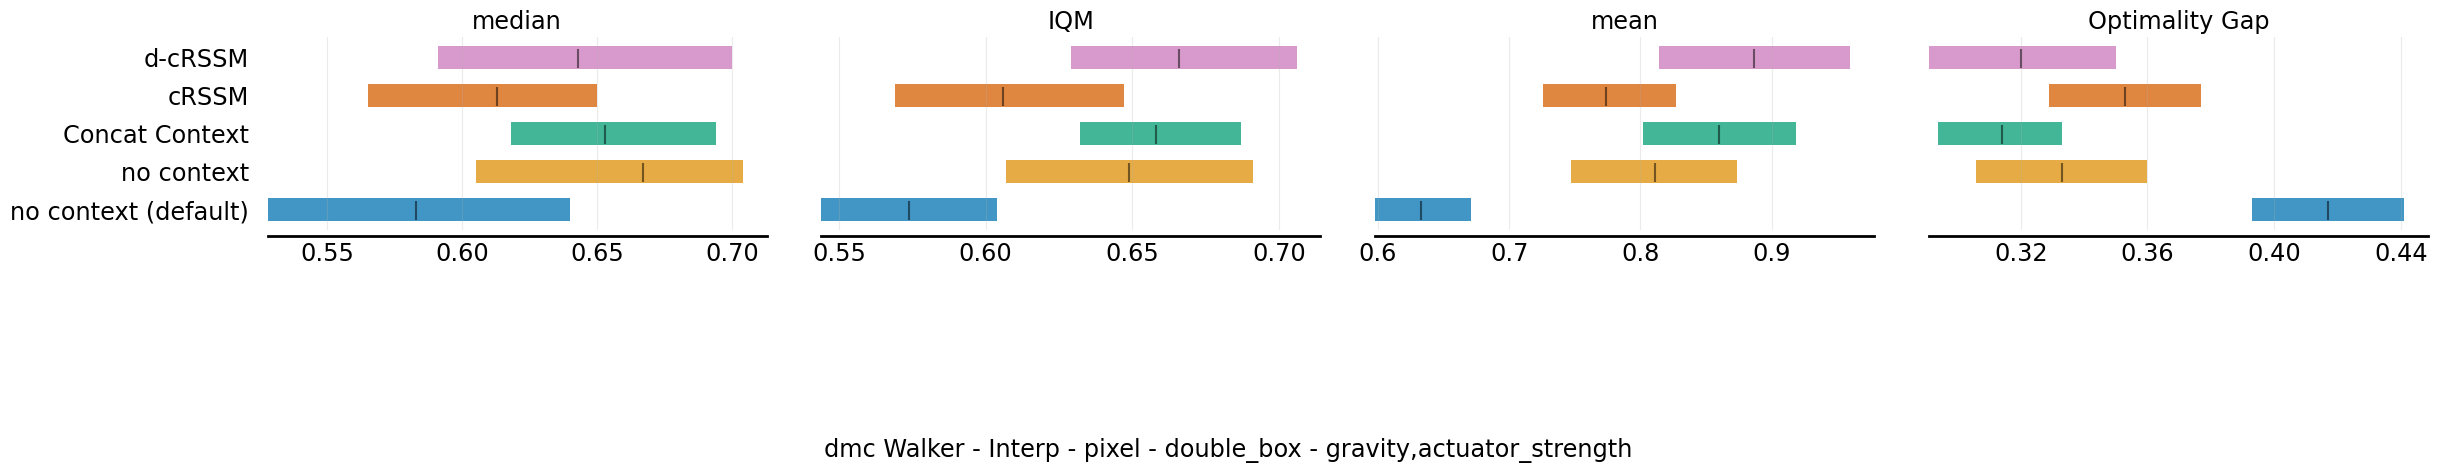

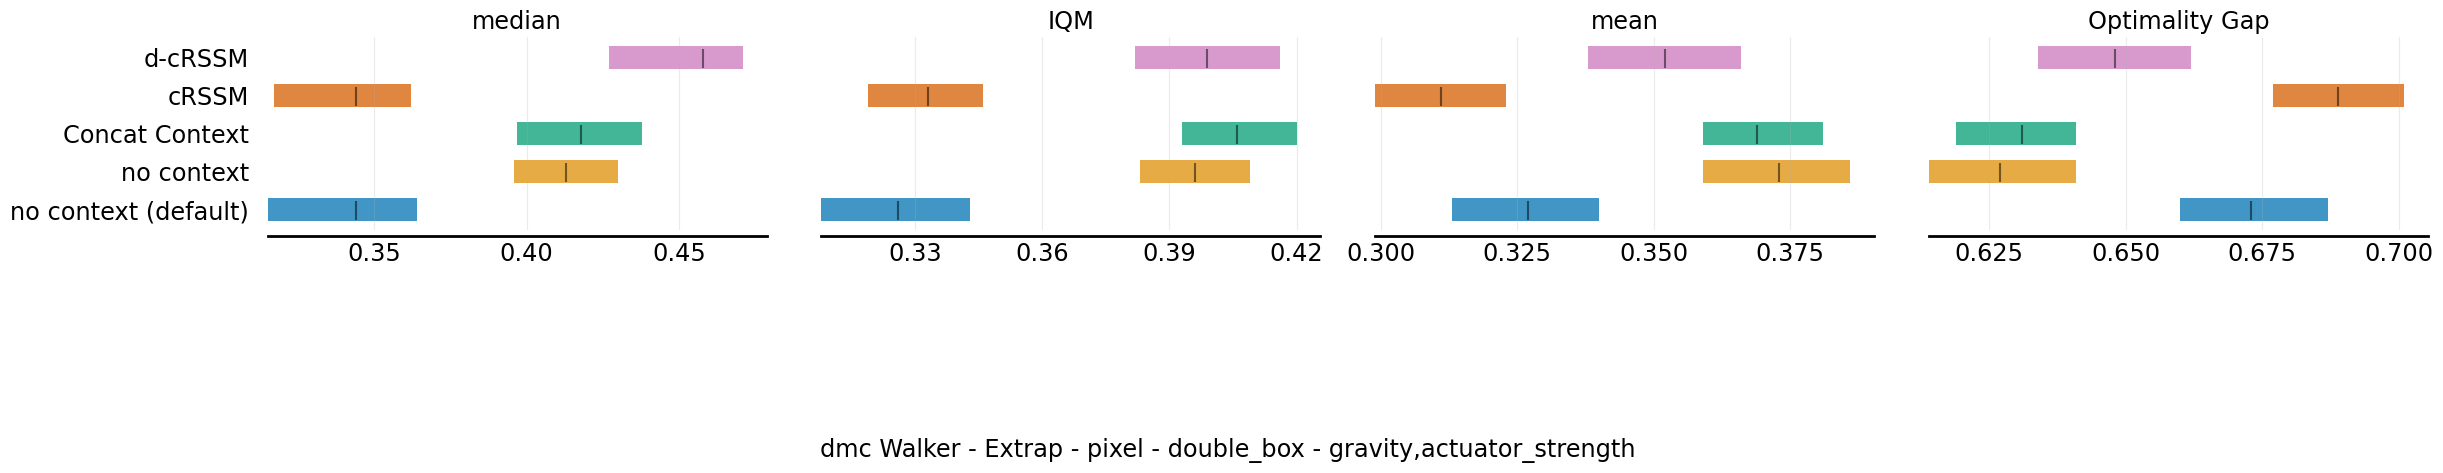

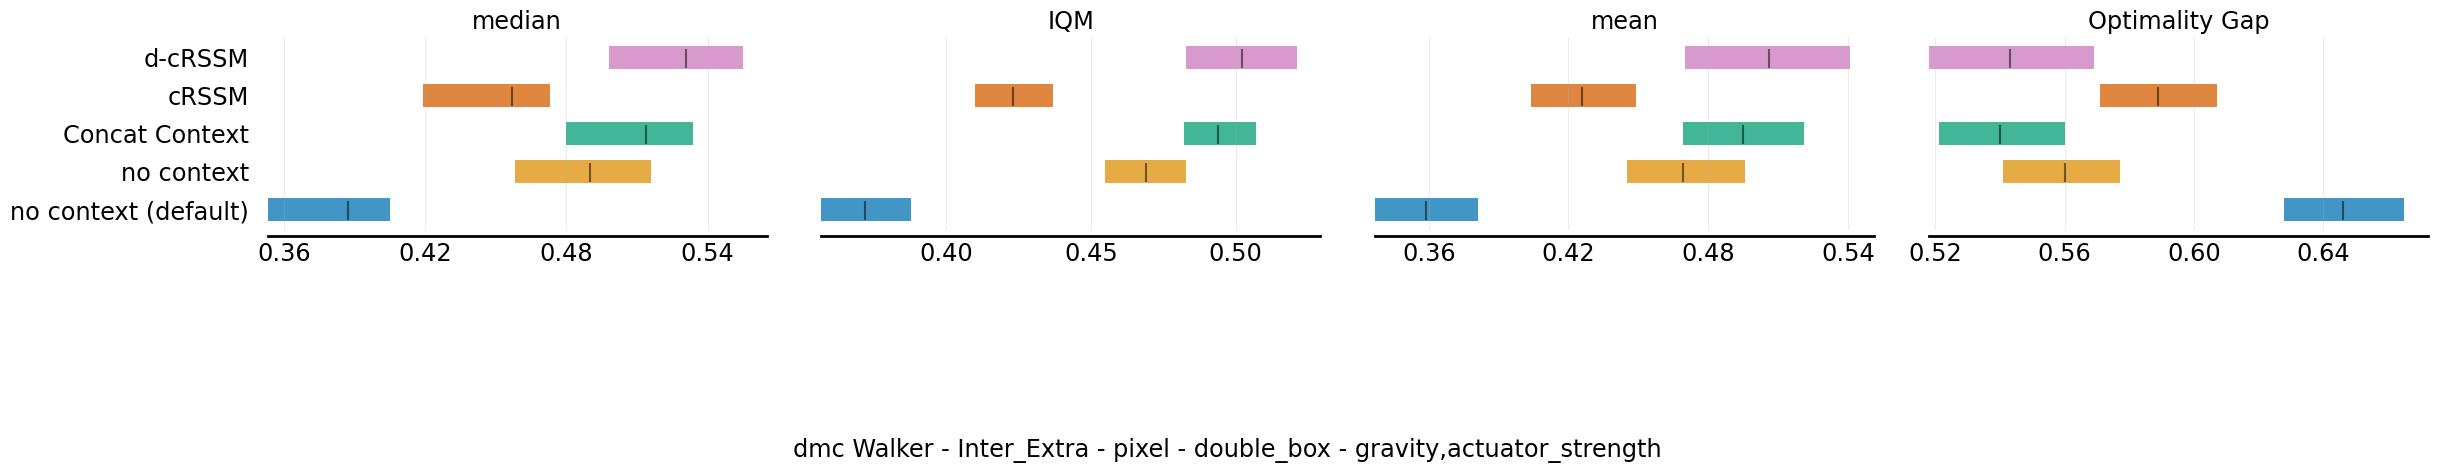

In [26]:
compare_plot_algorithms(df_small)

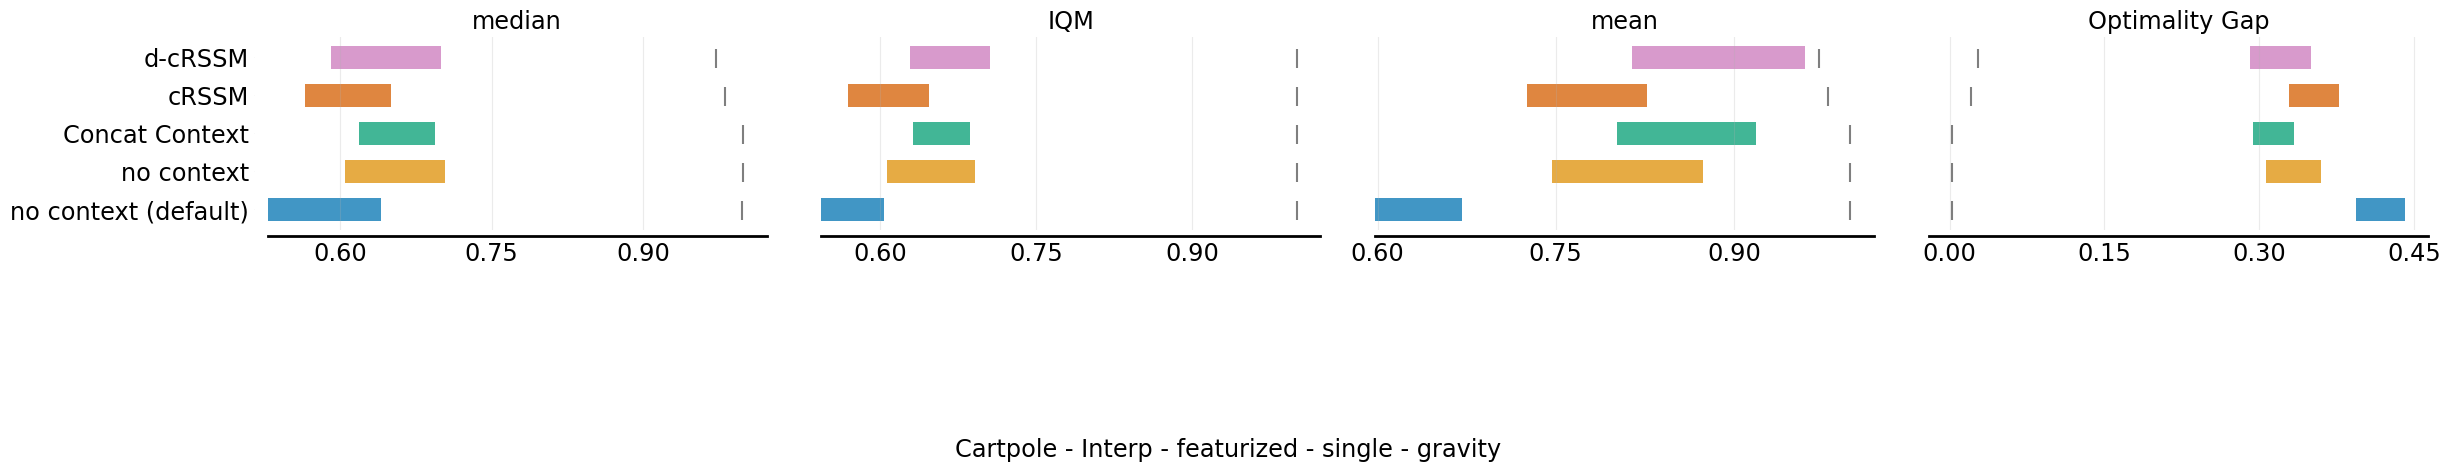

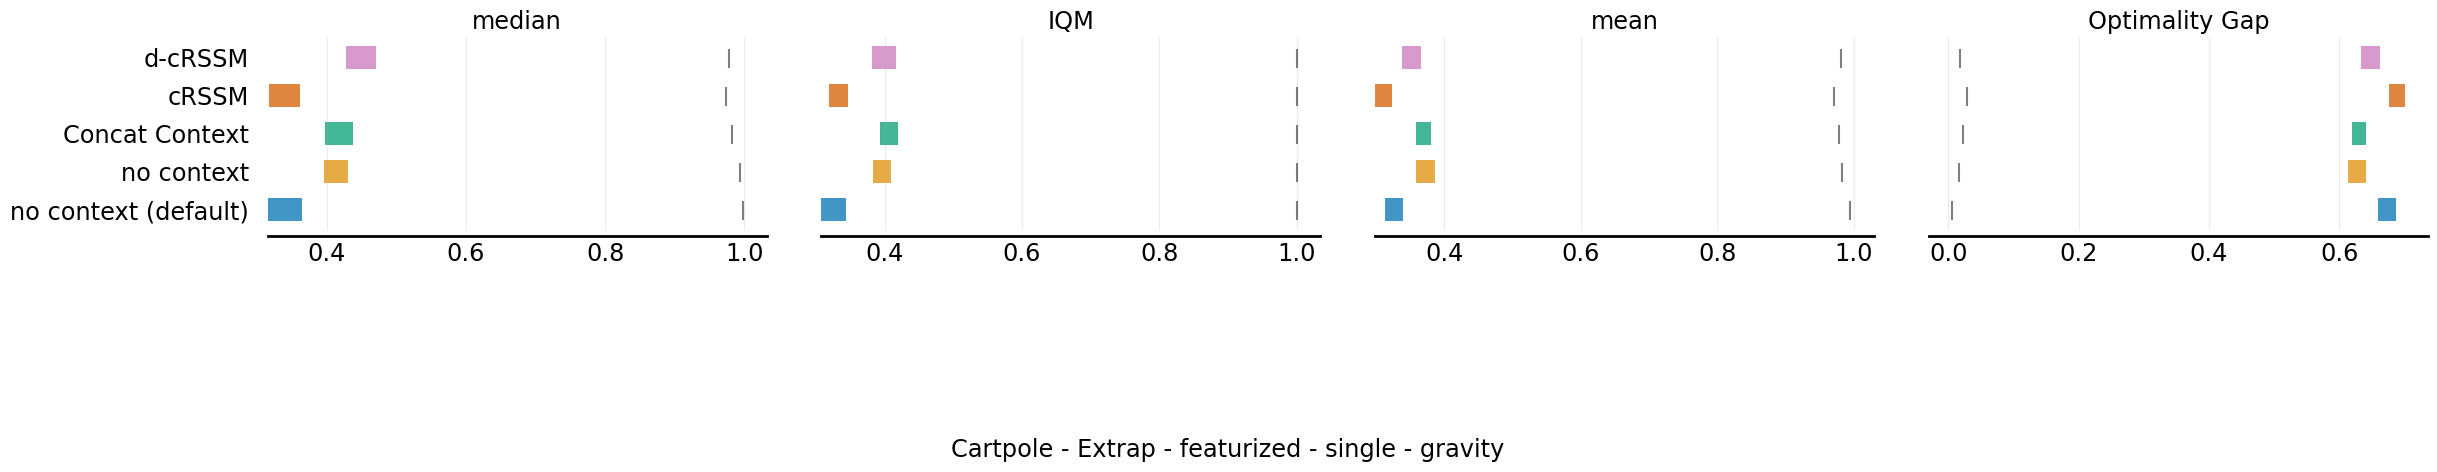

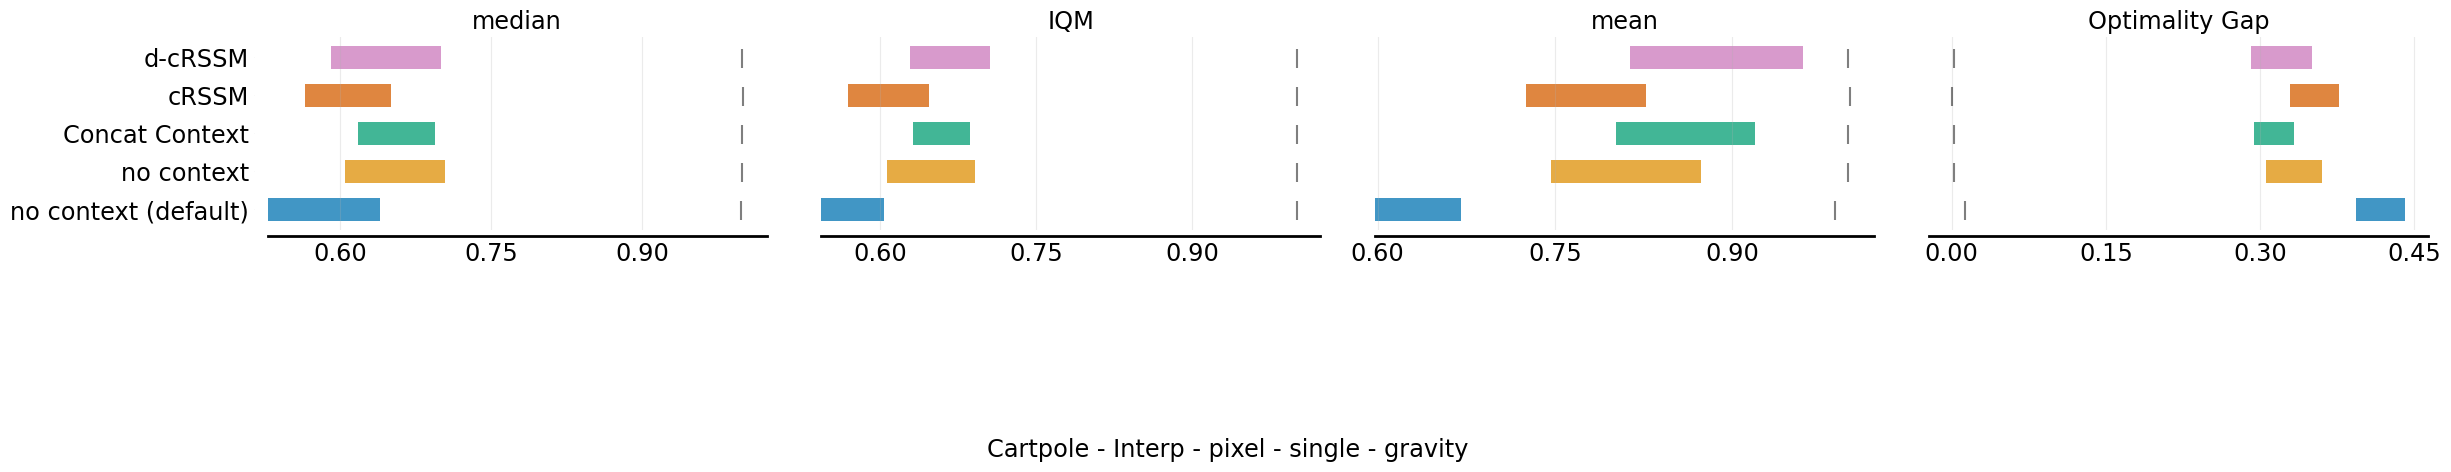

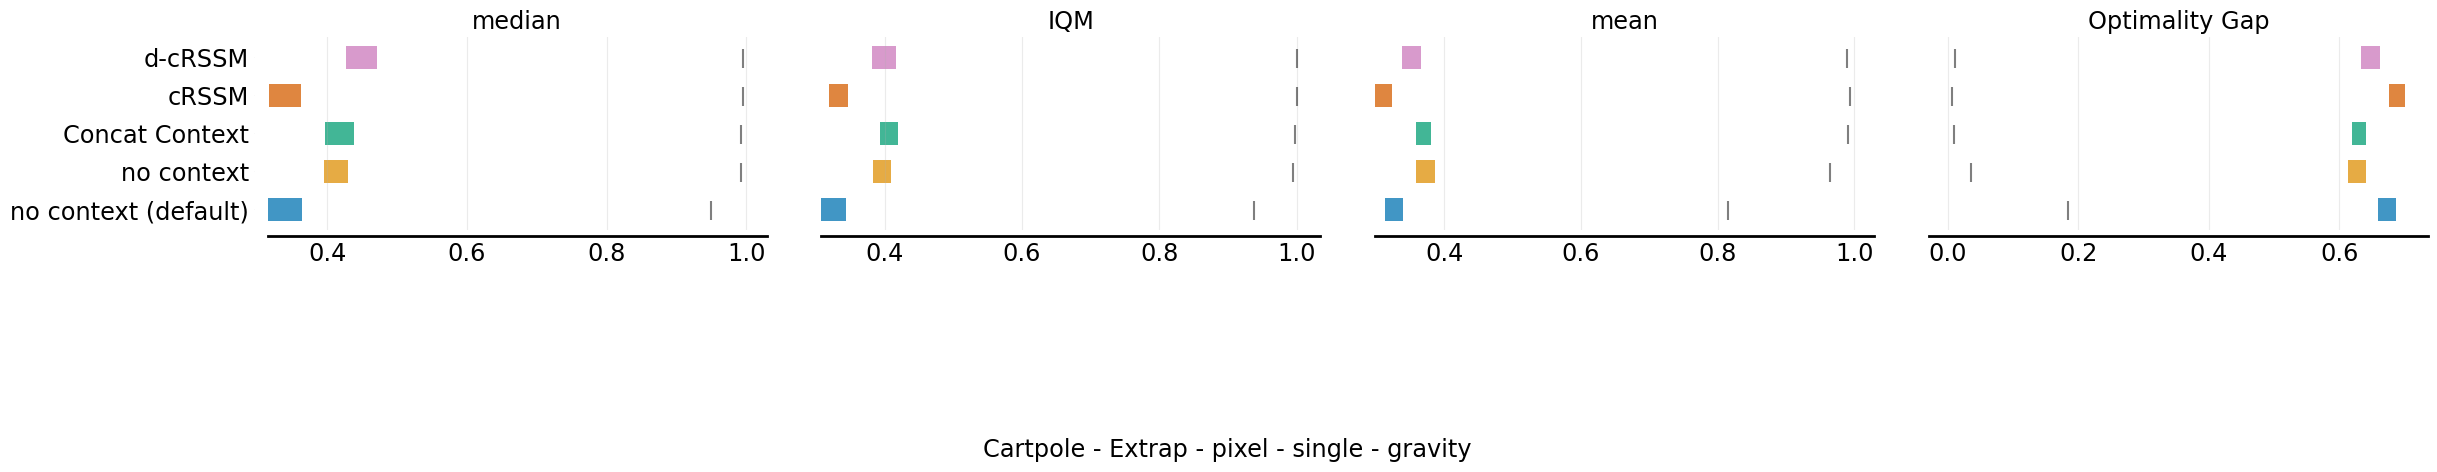

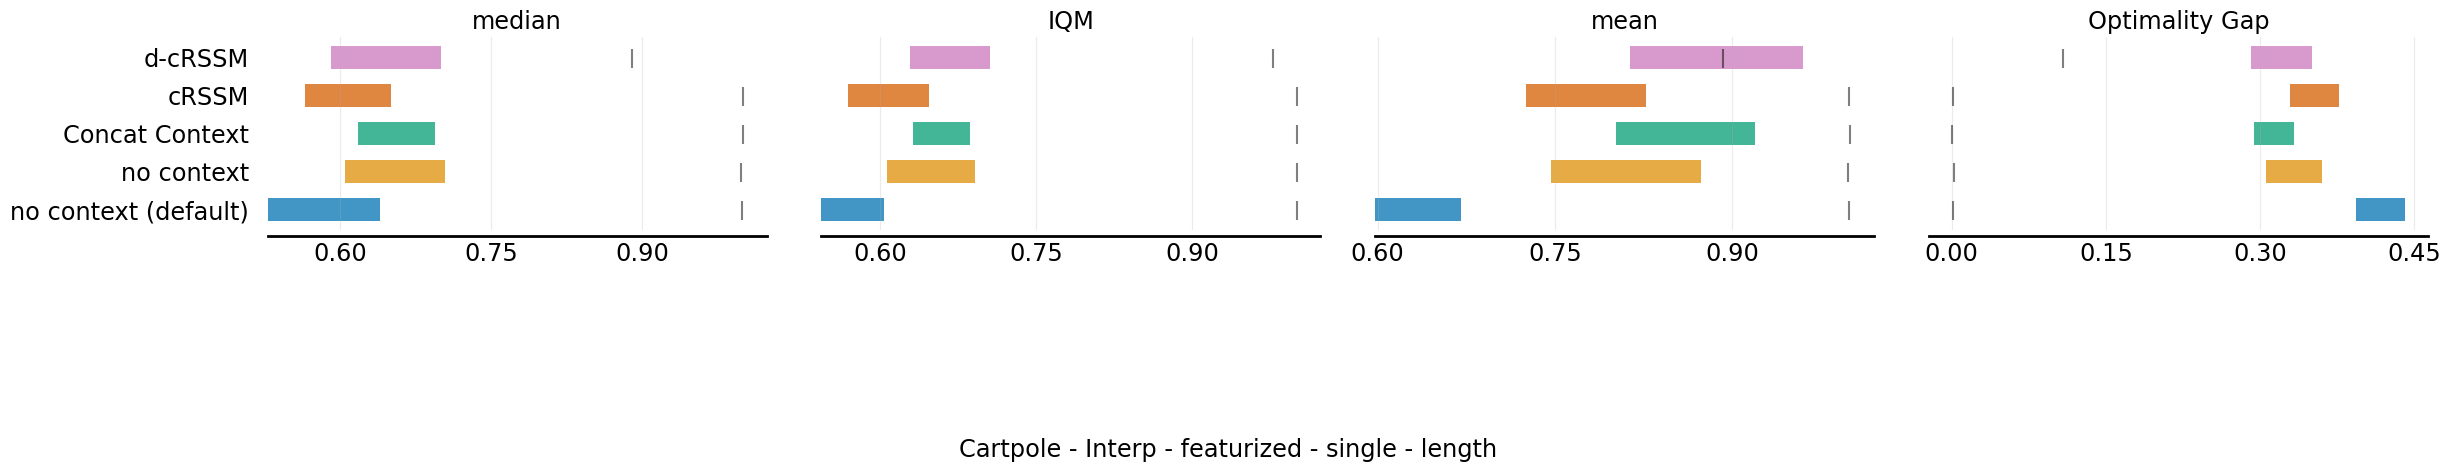

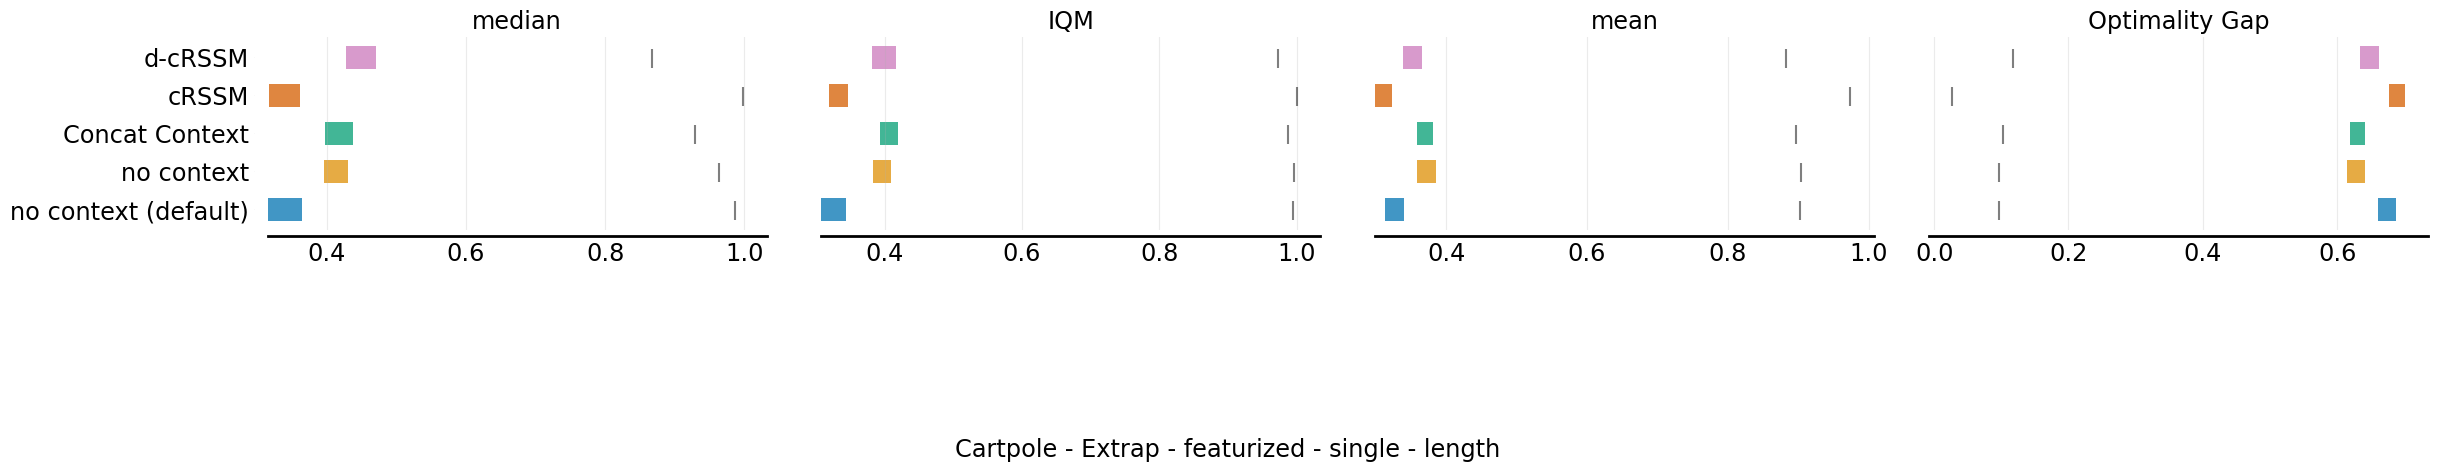

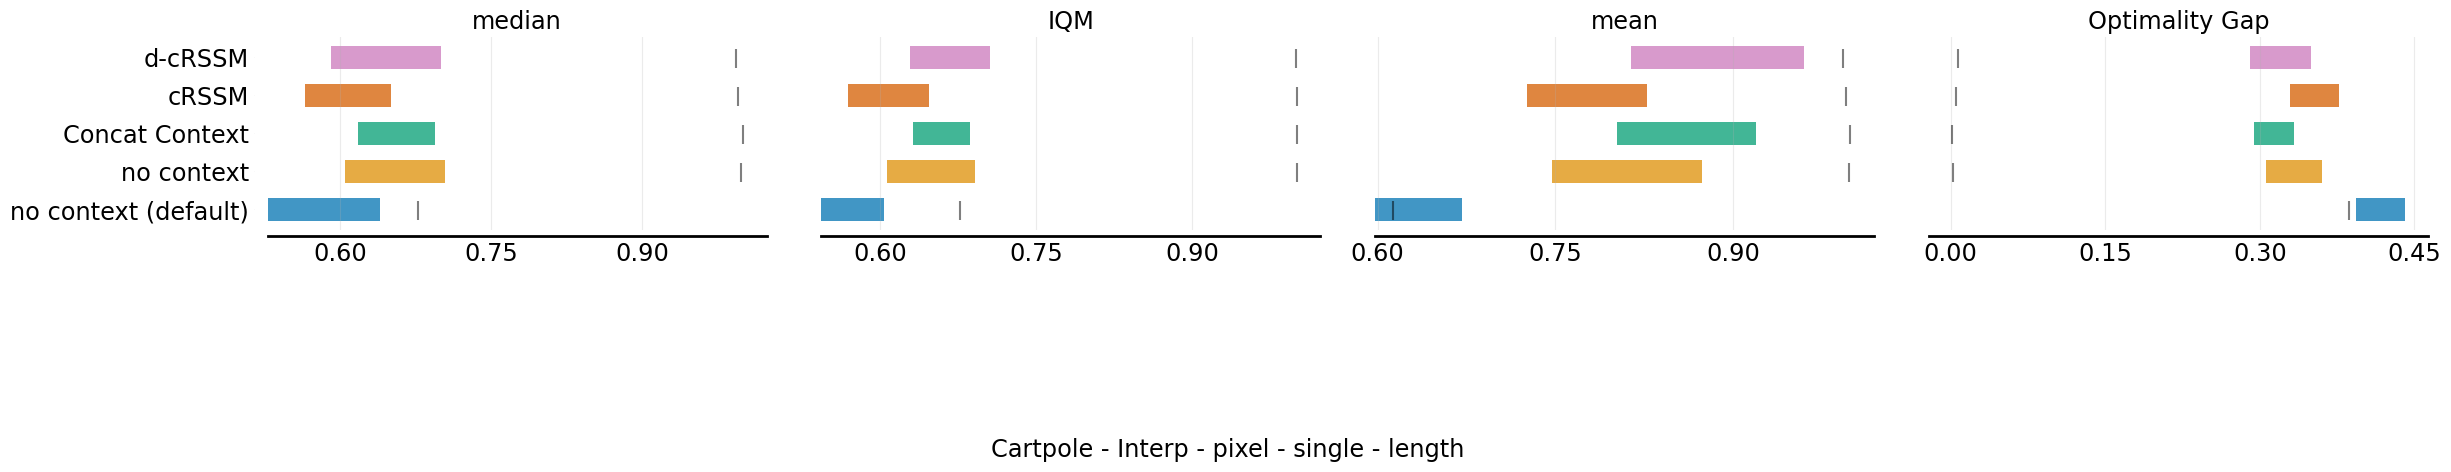

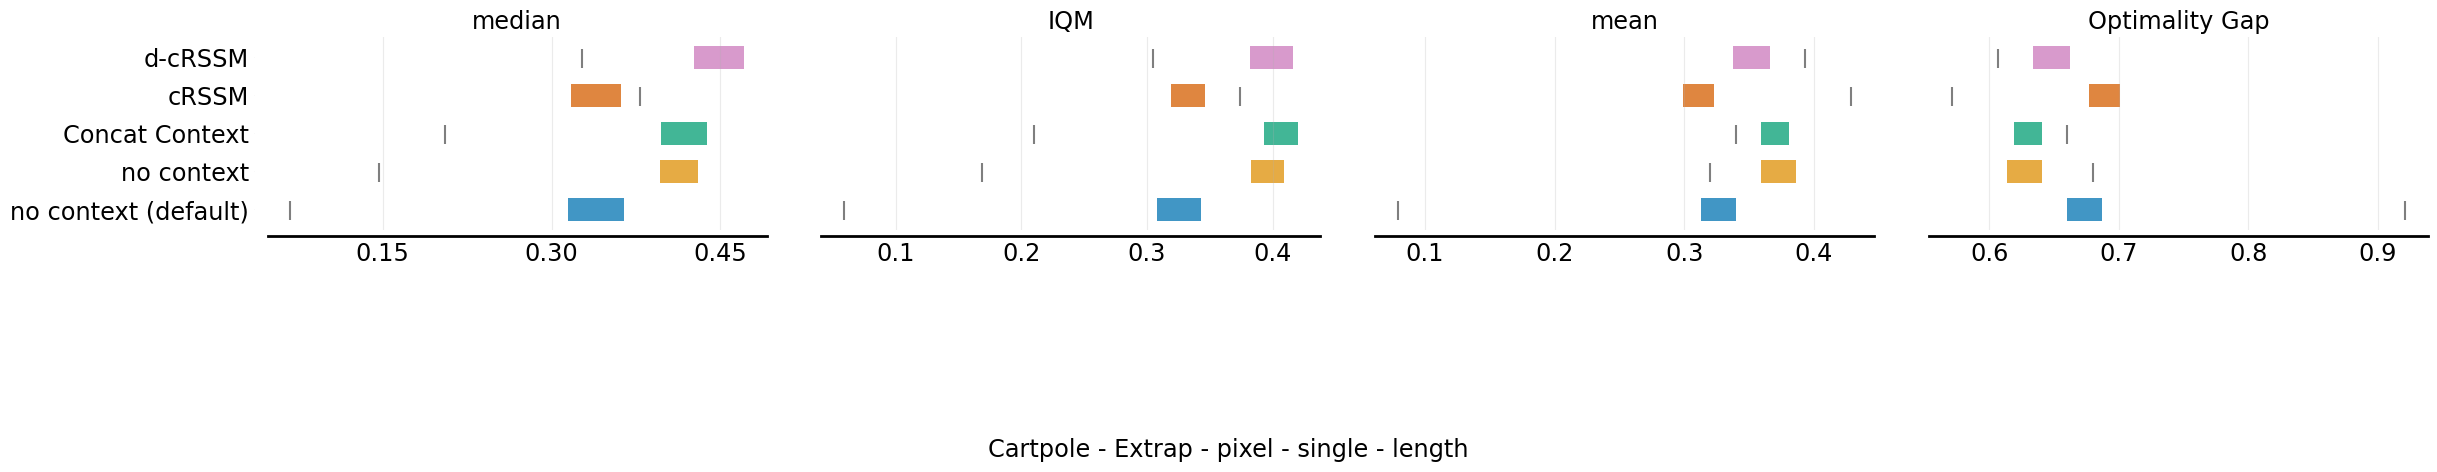

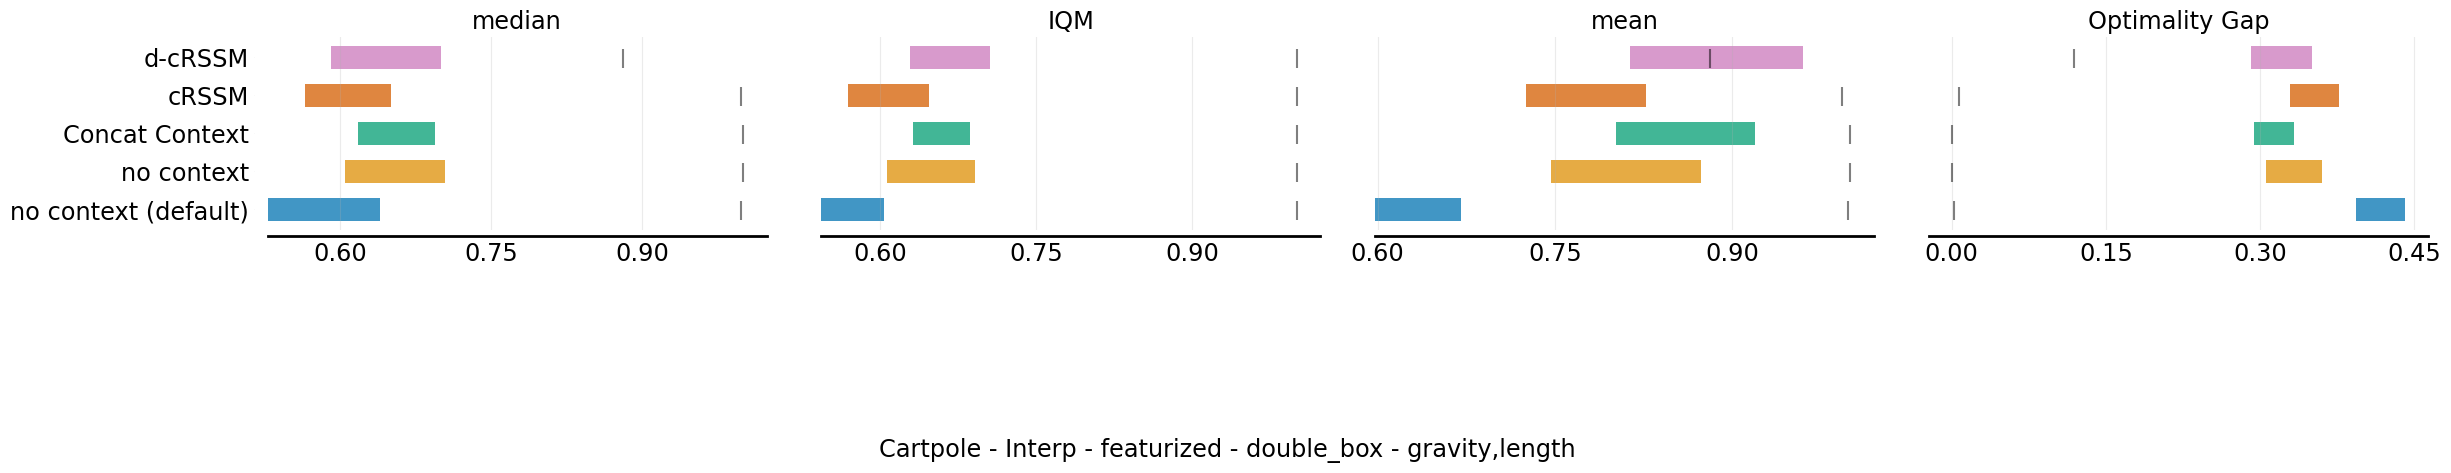

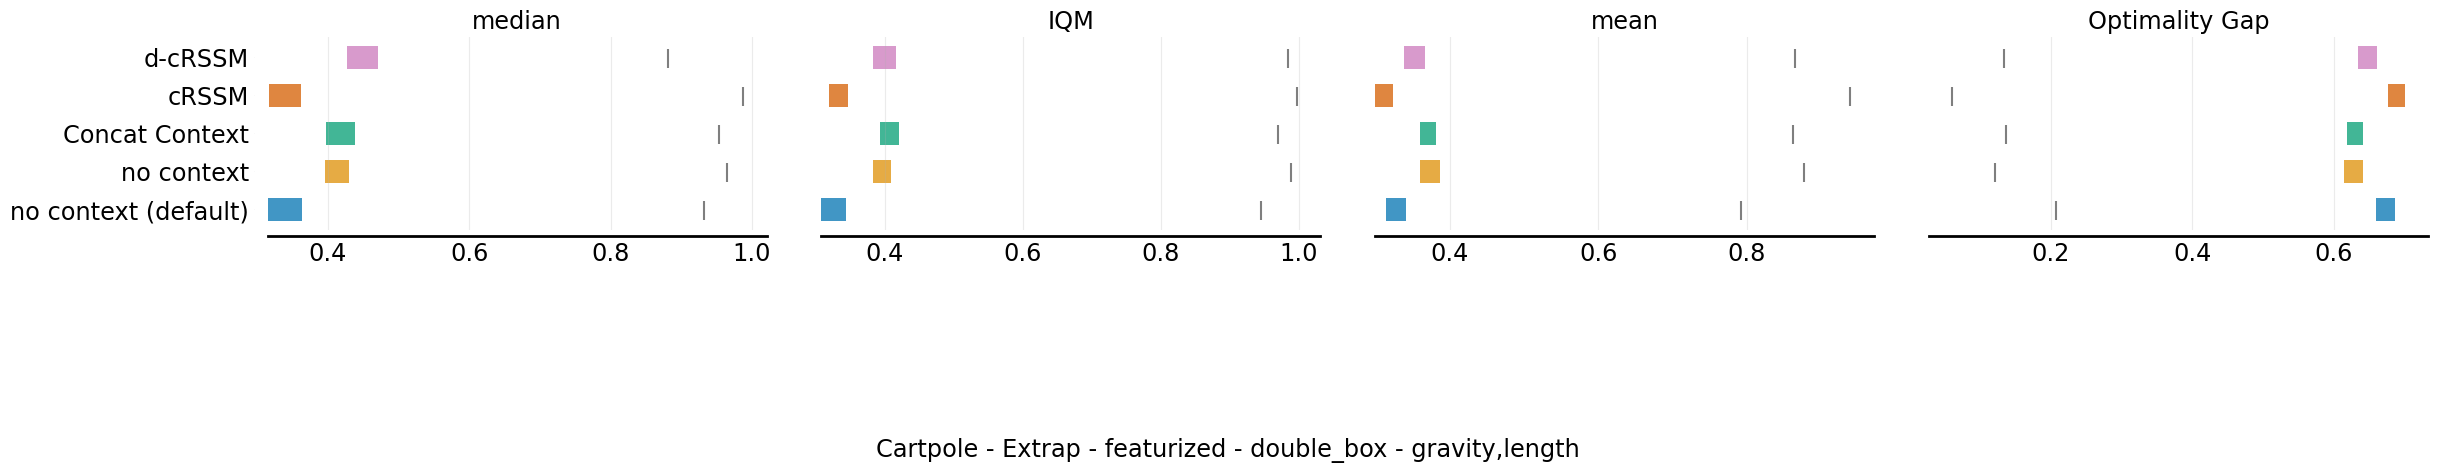

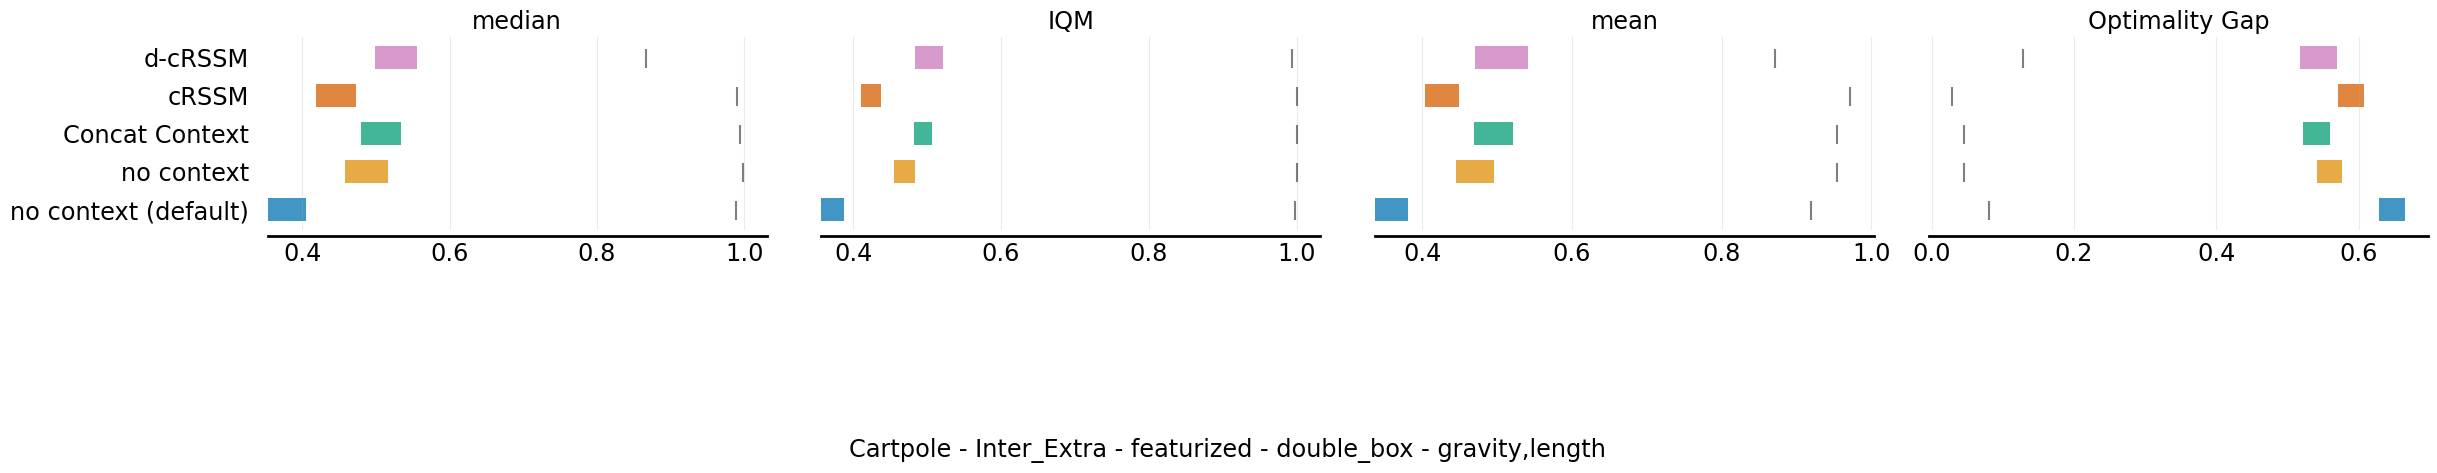

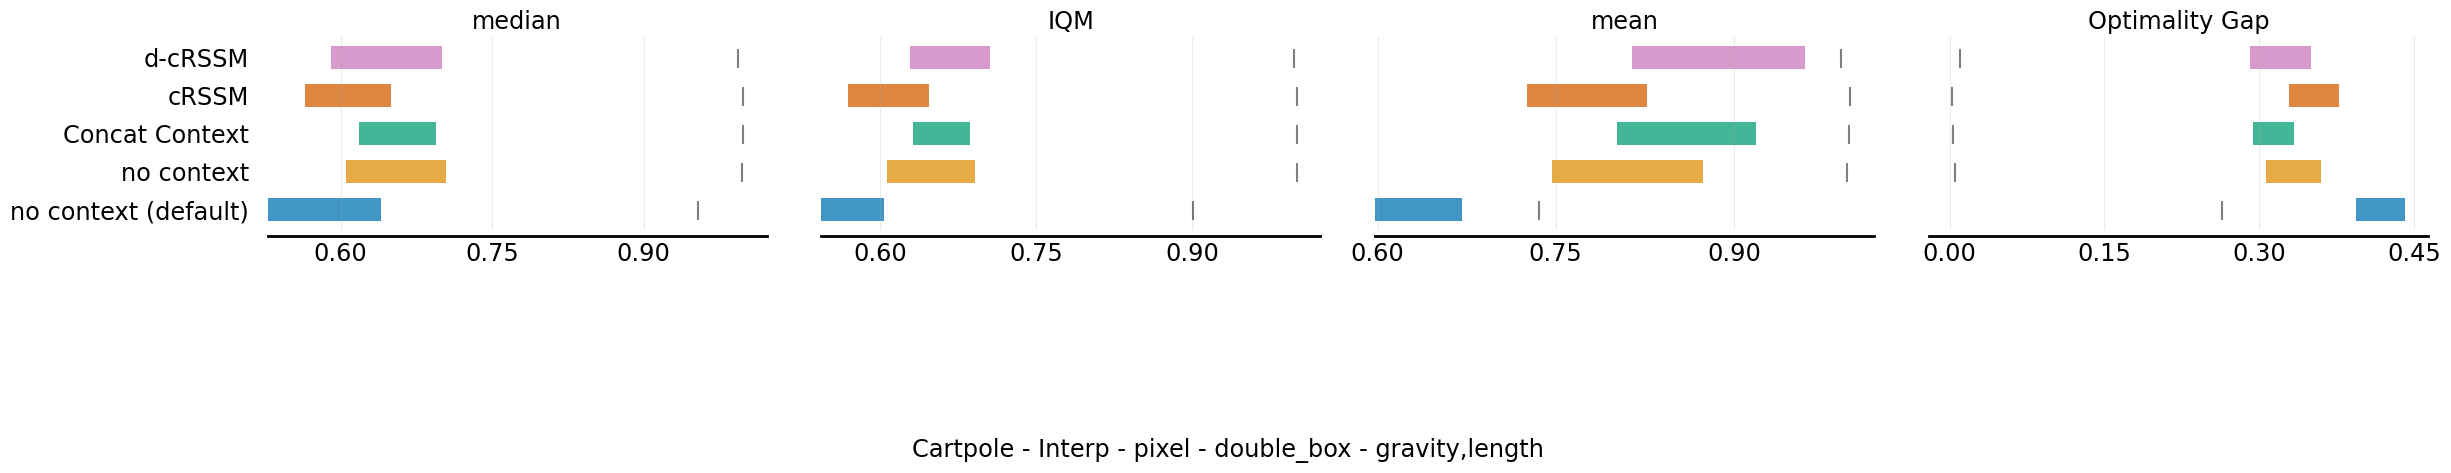

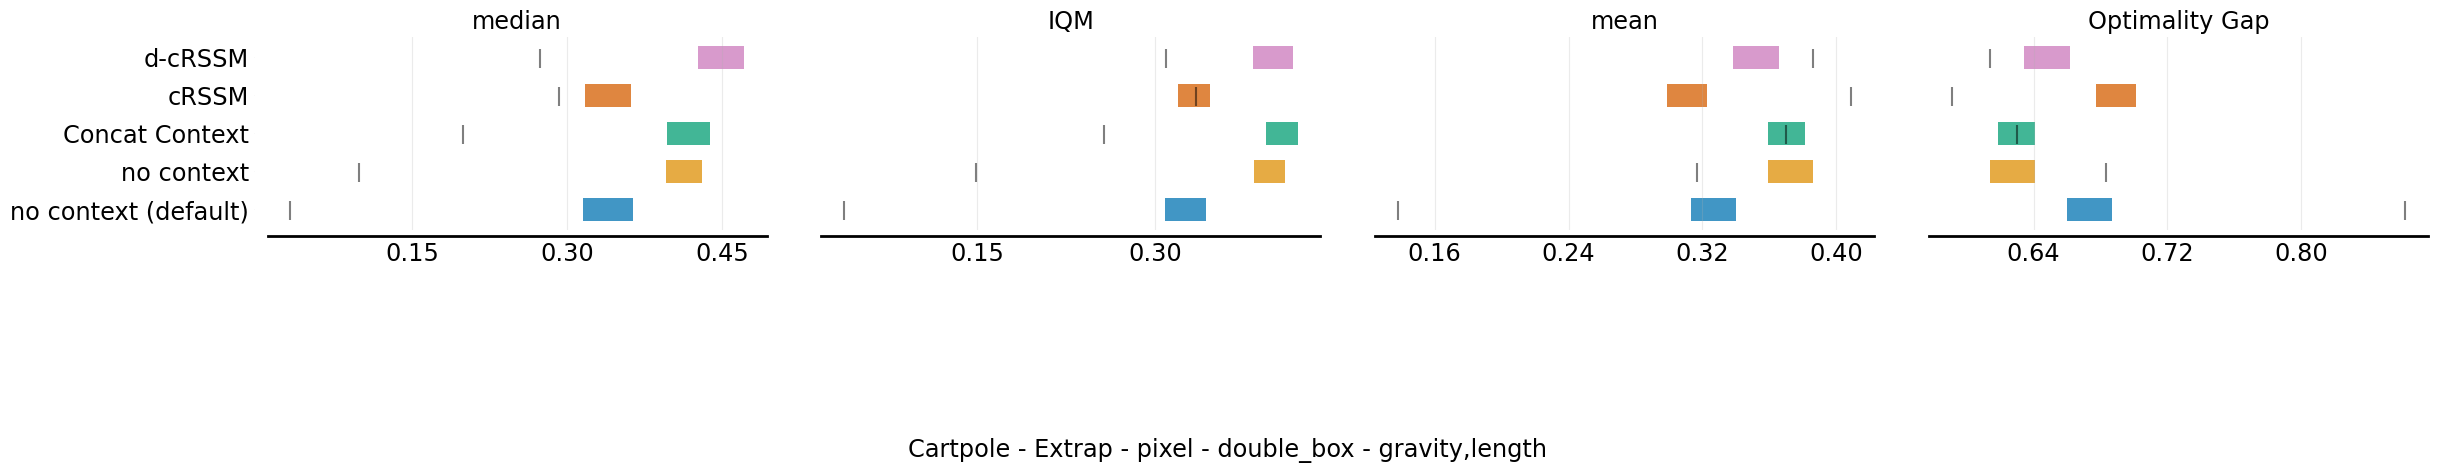

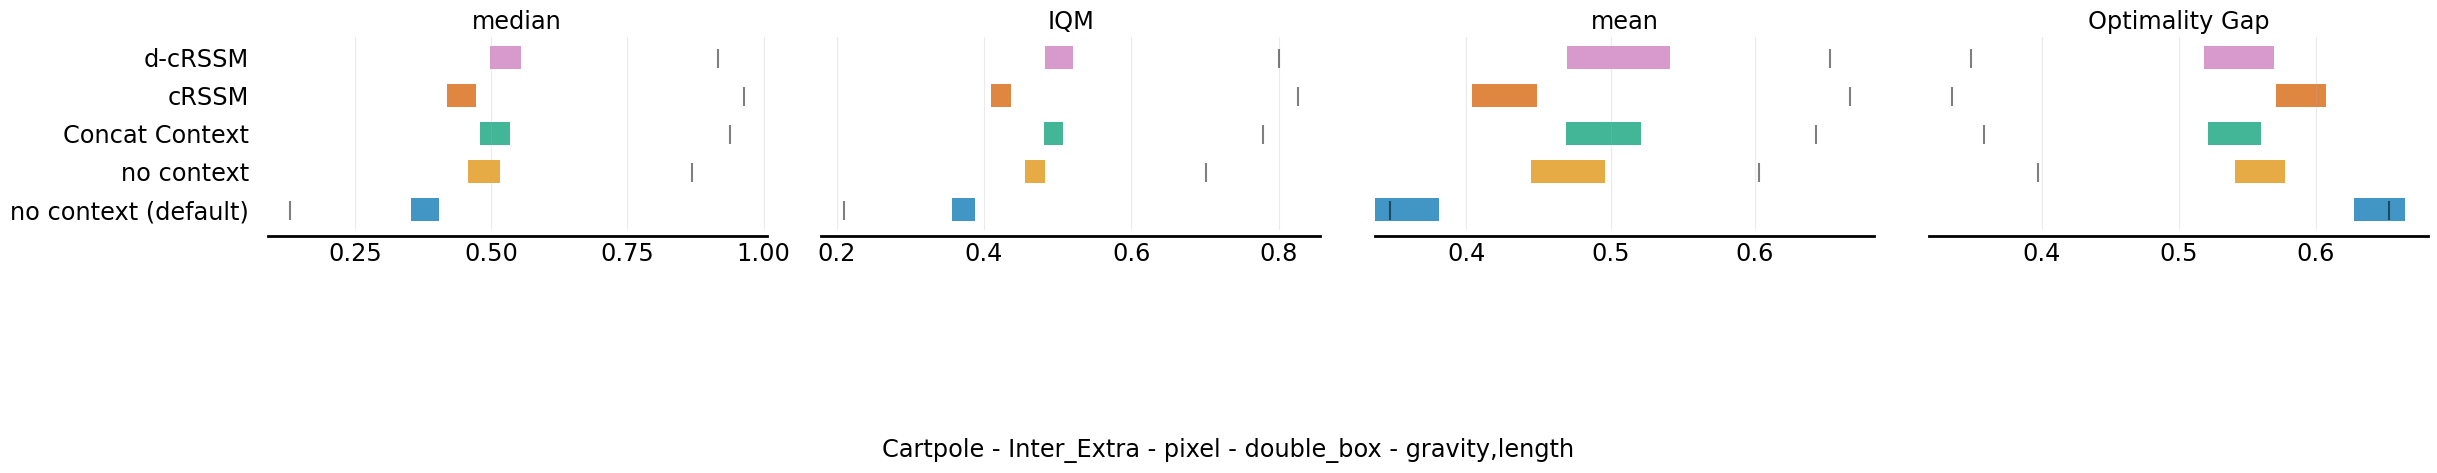

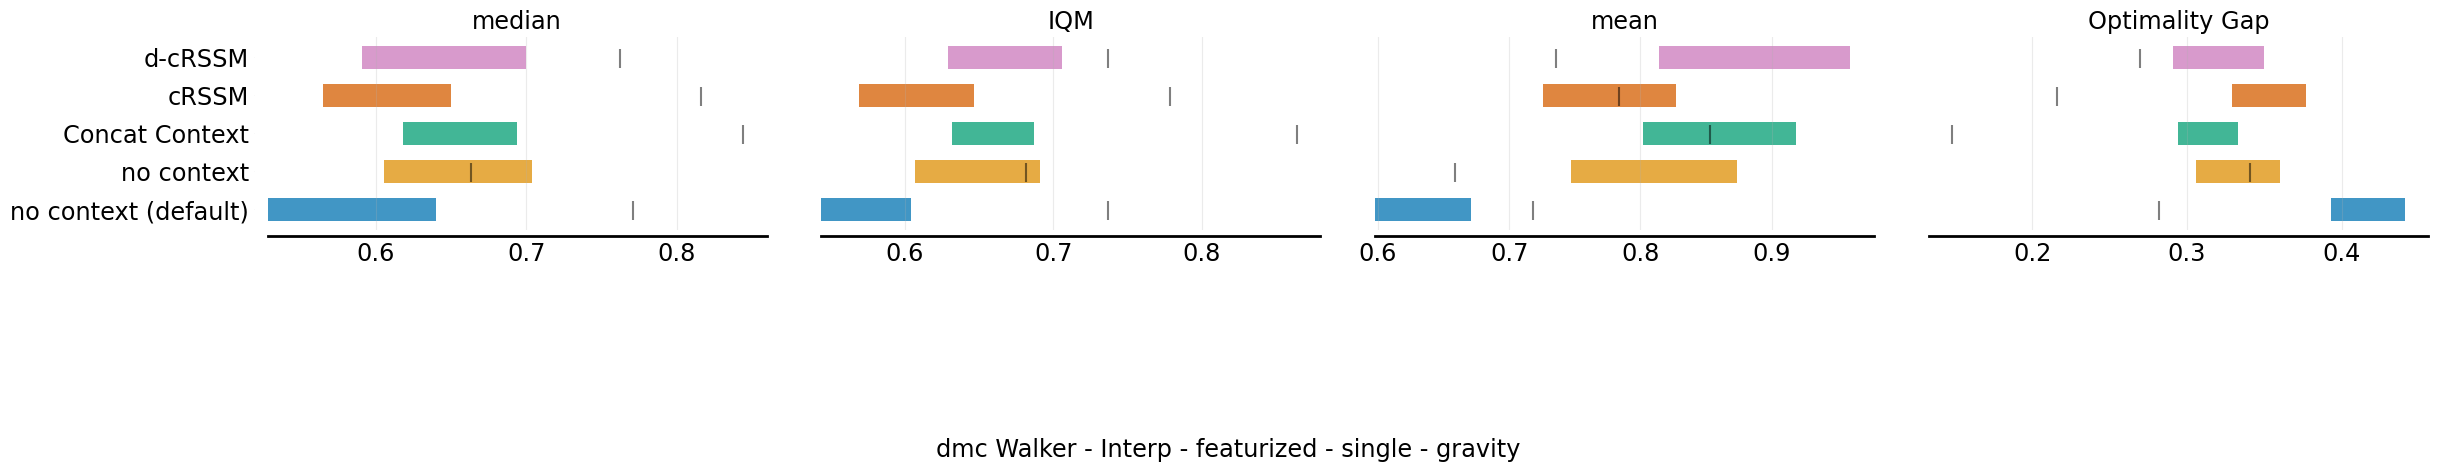

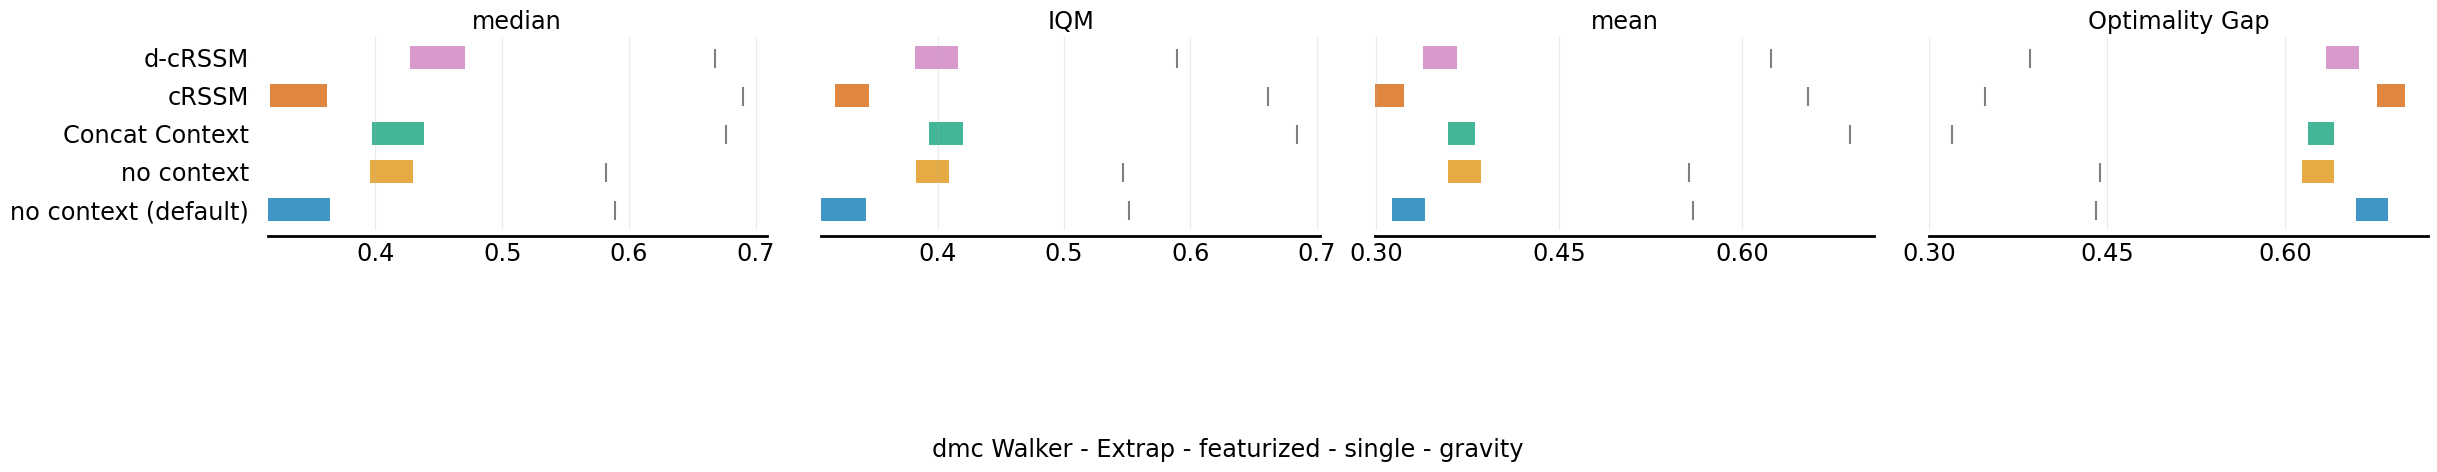

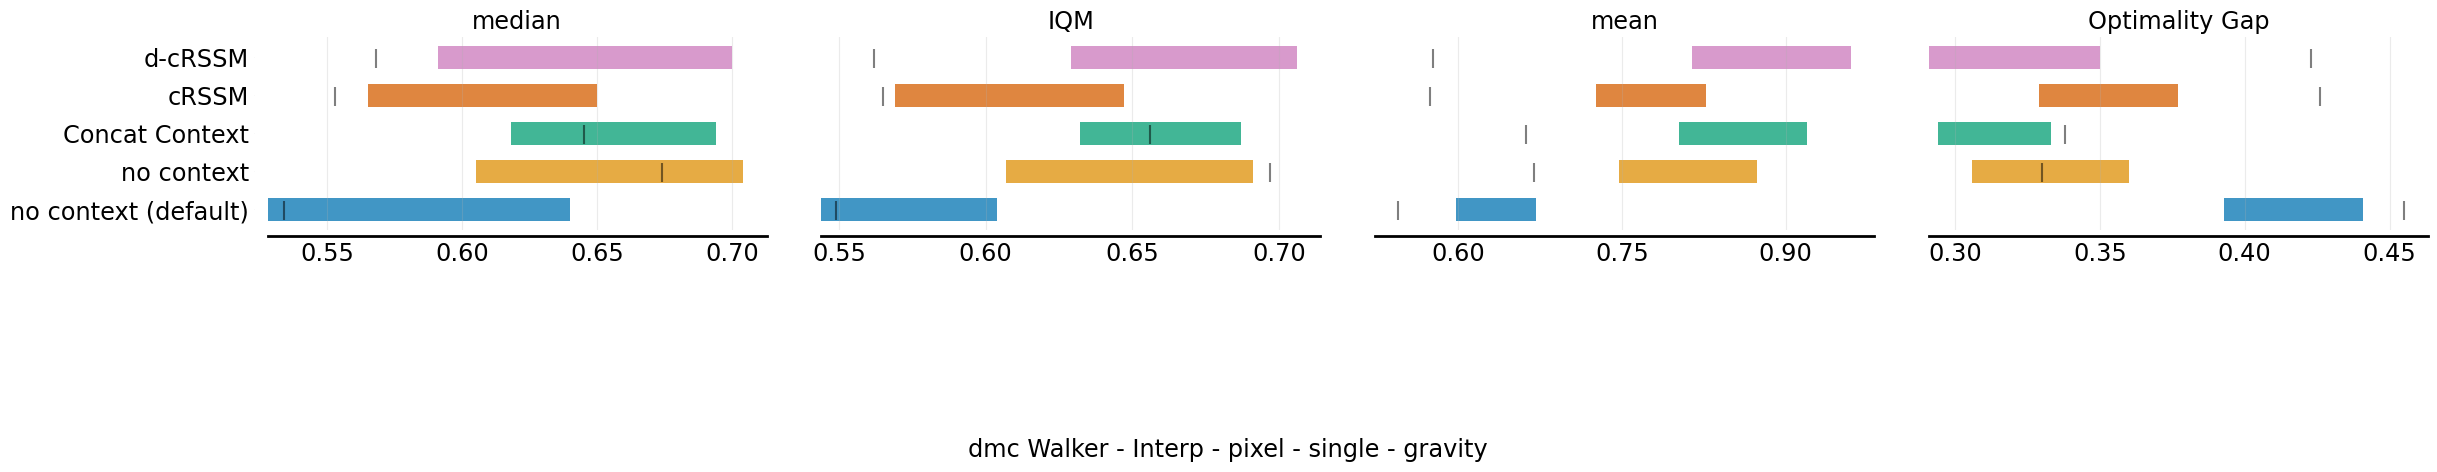

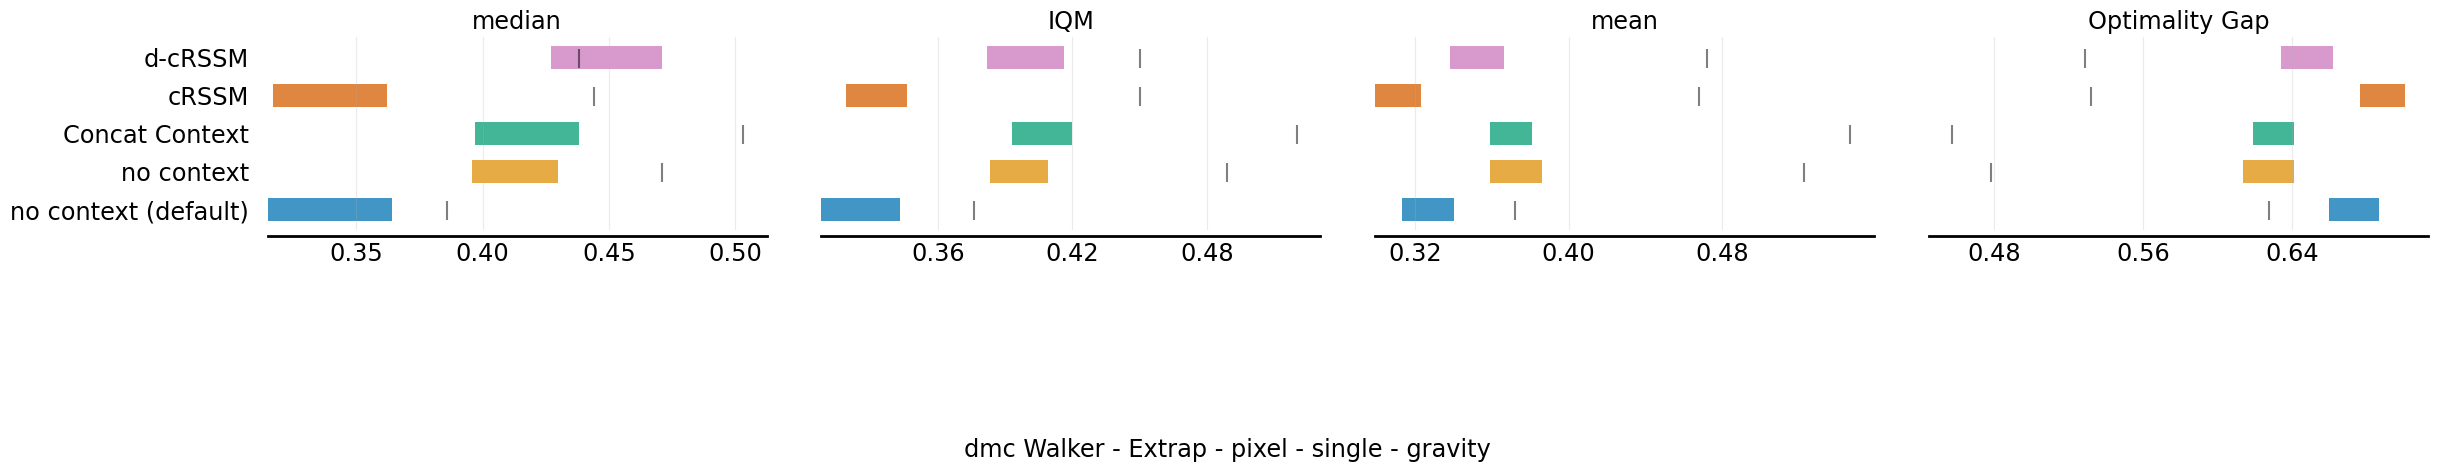

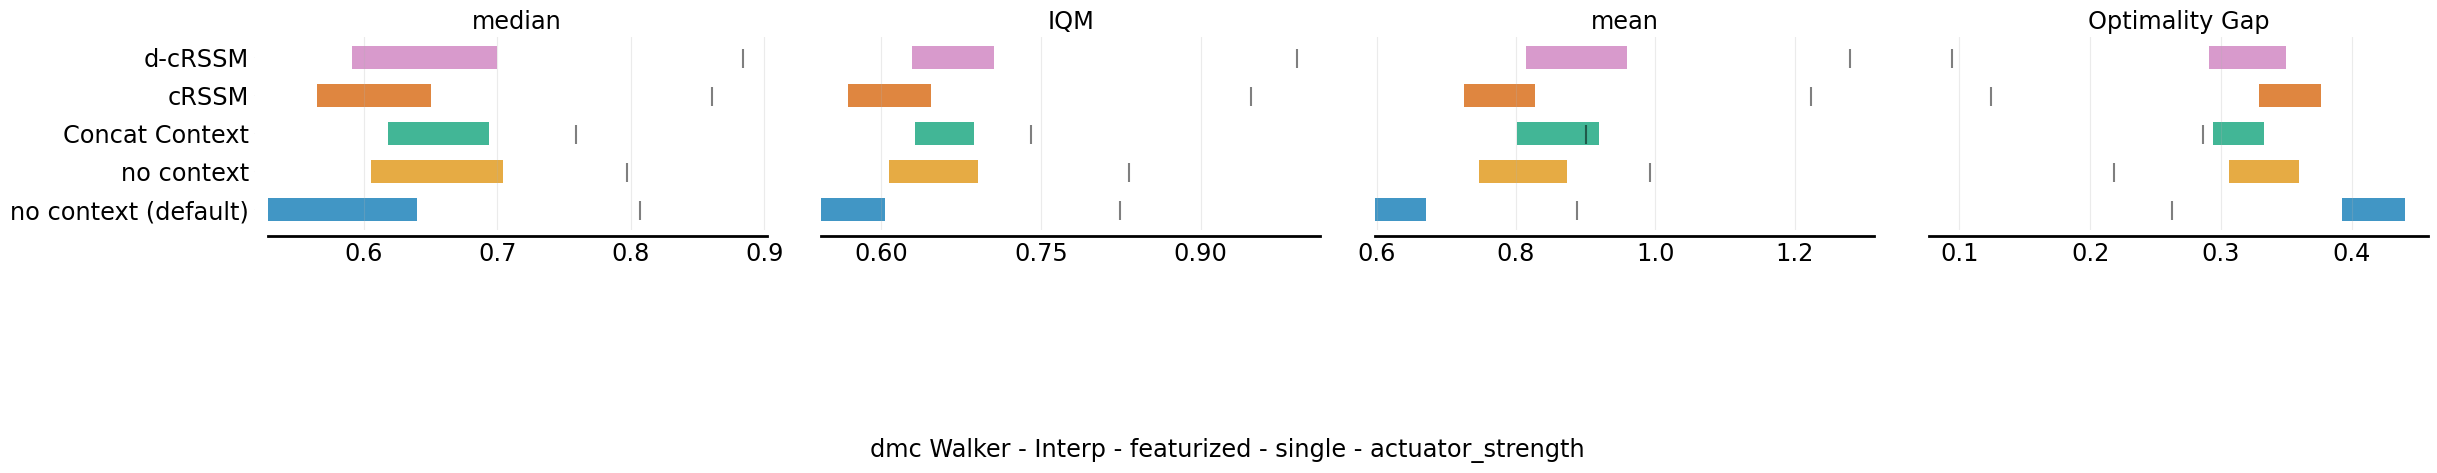

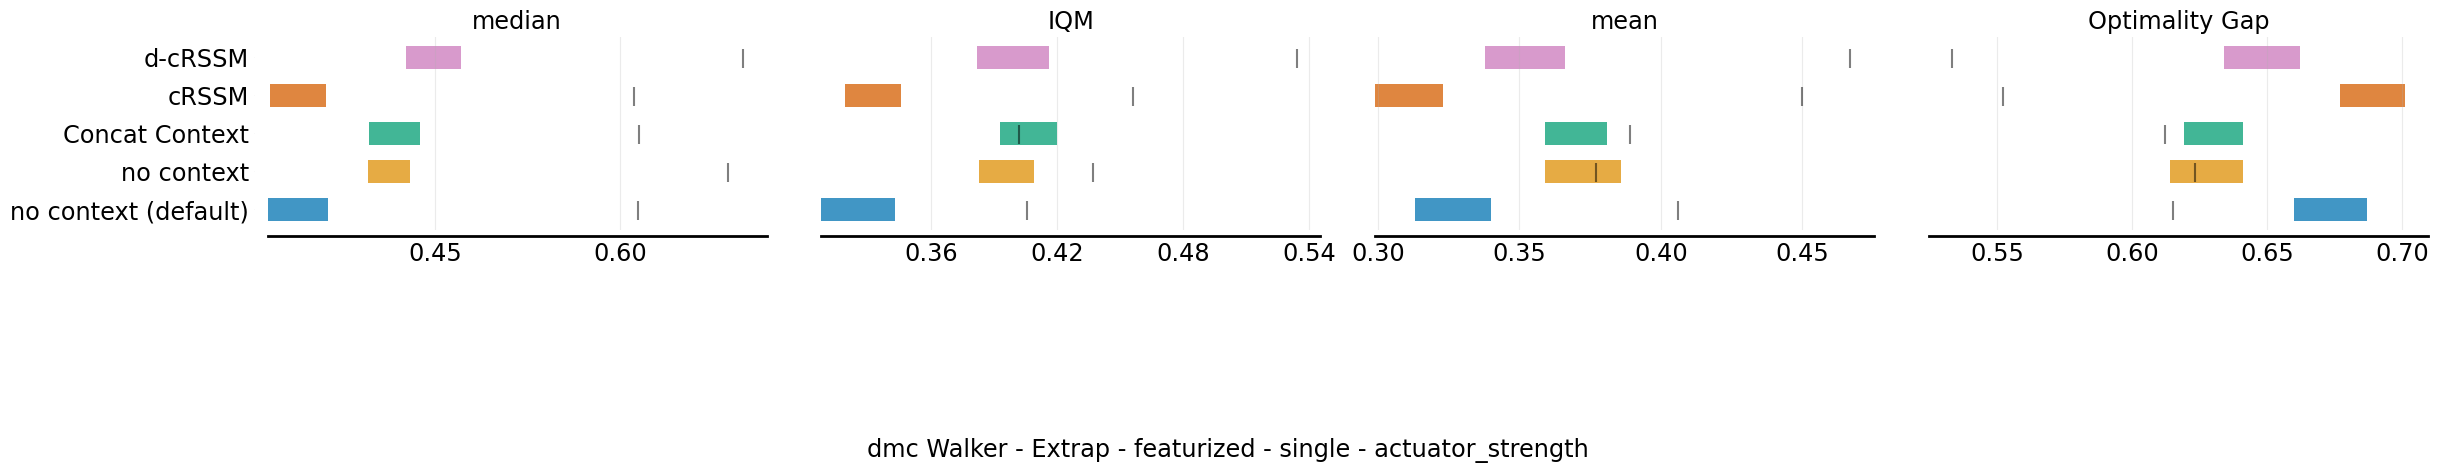

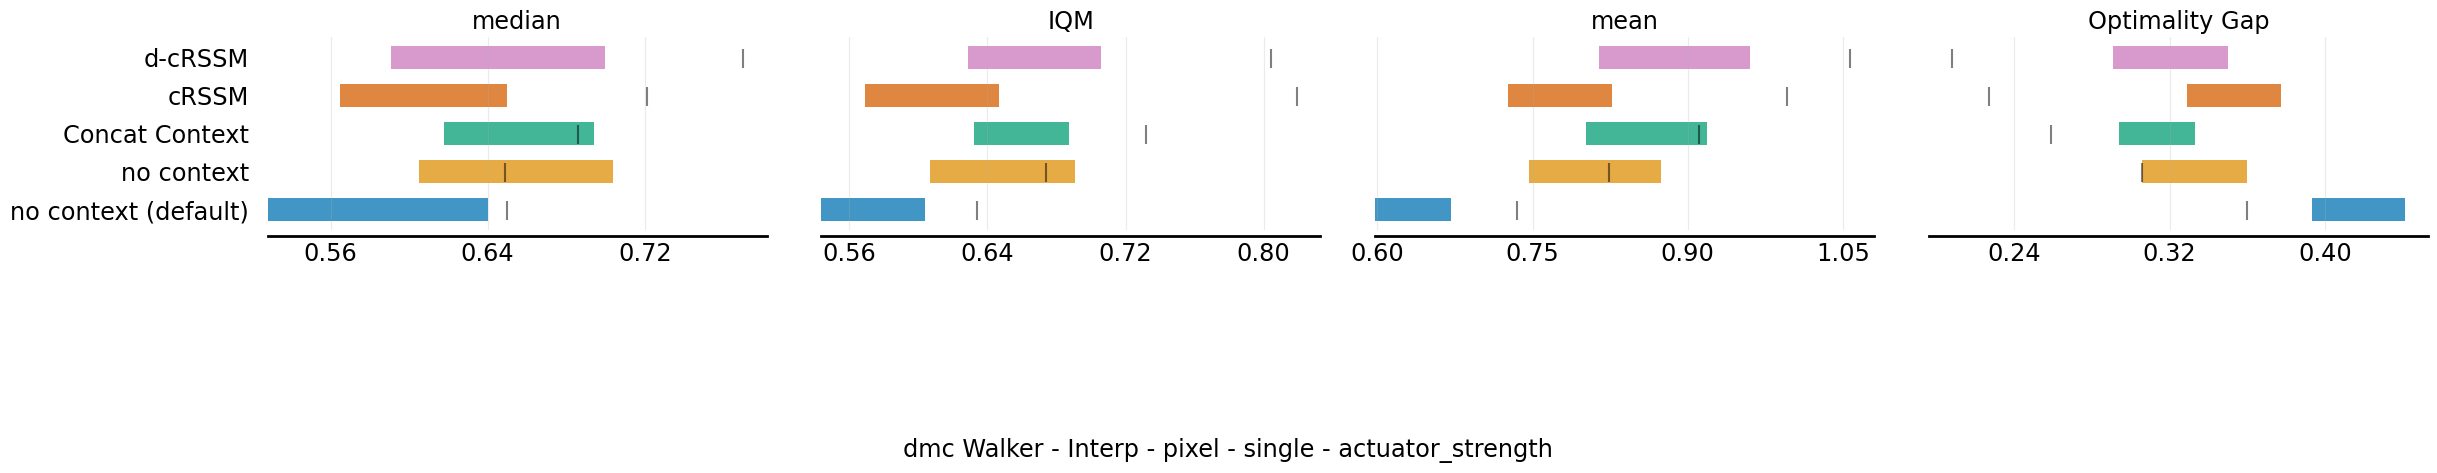

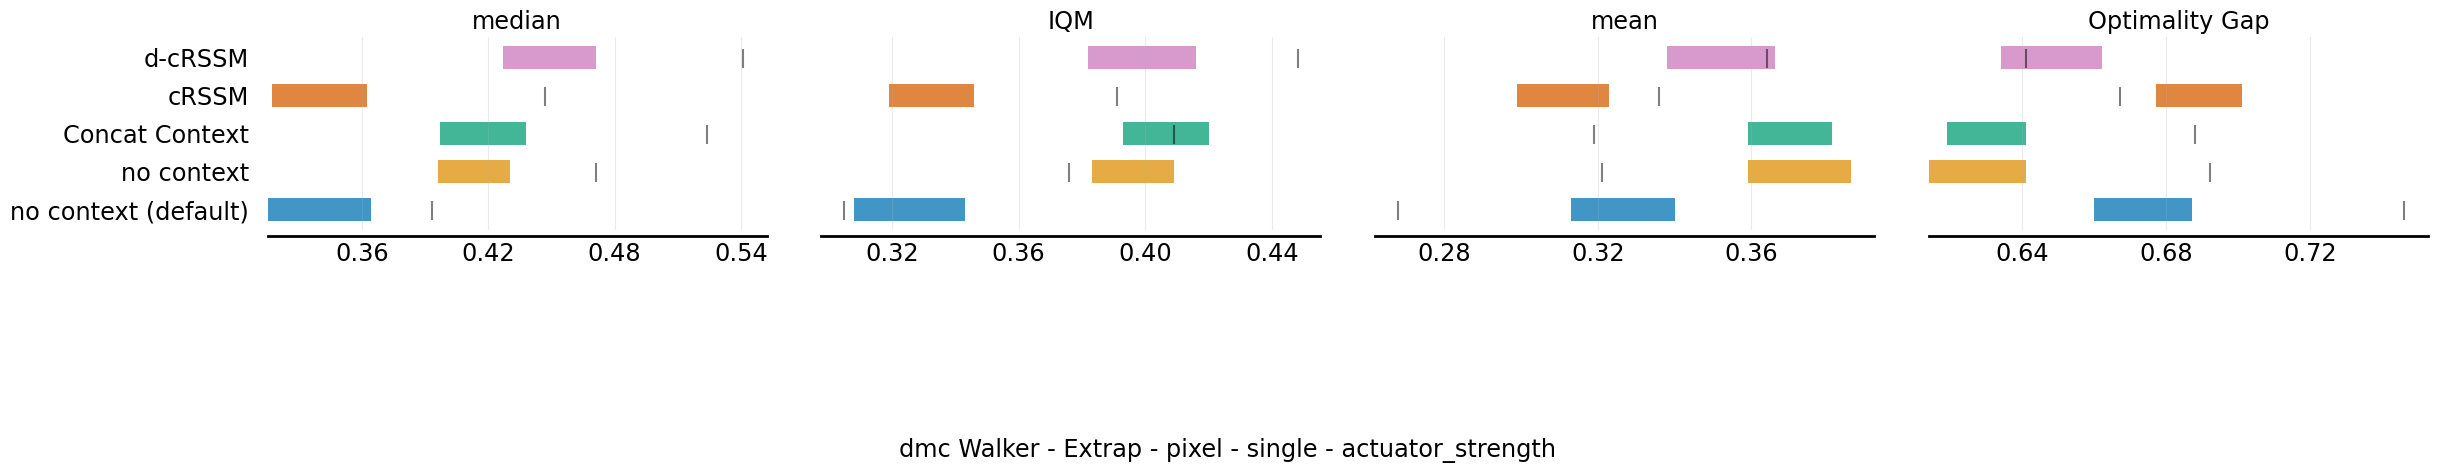

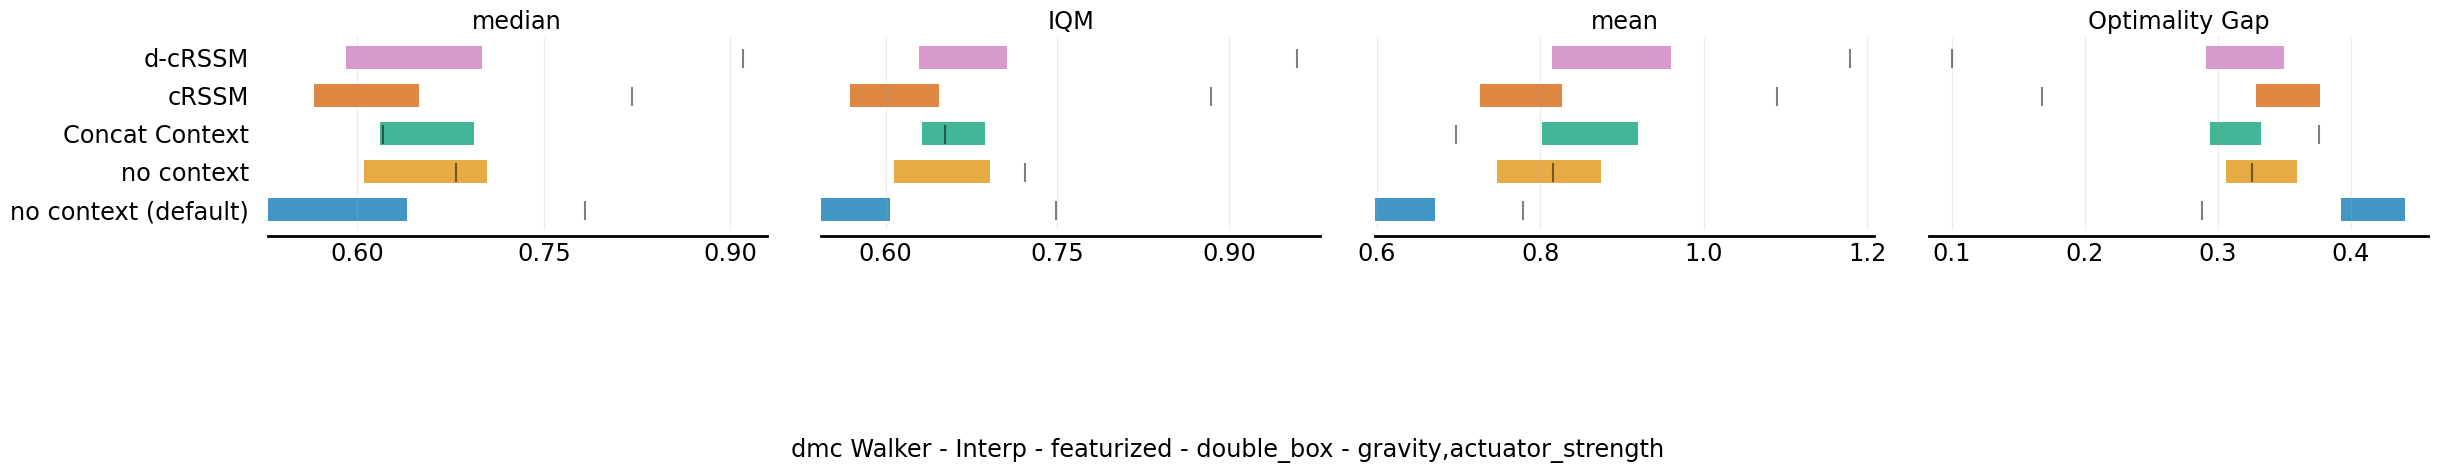

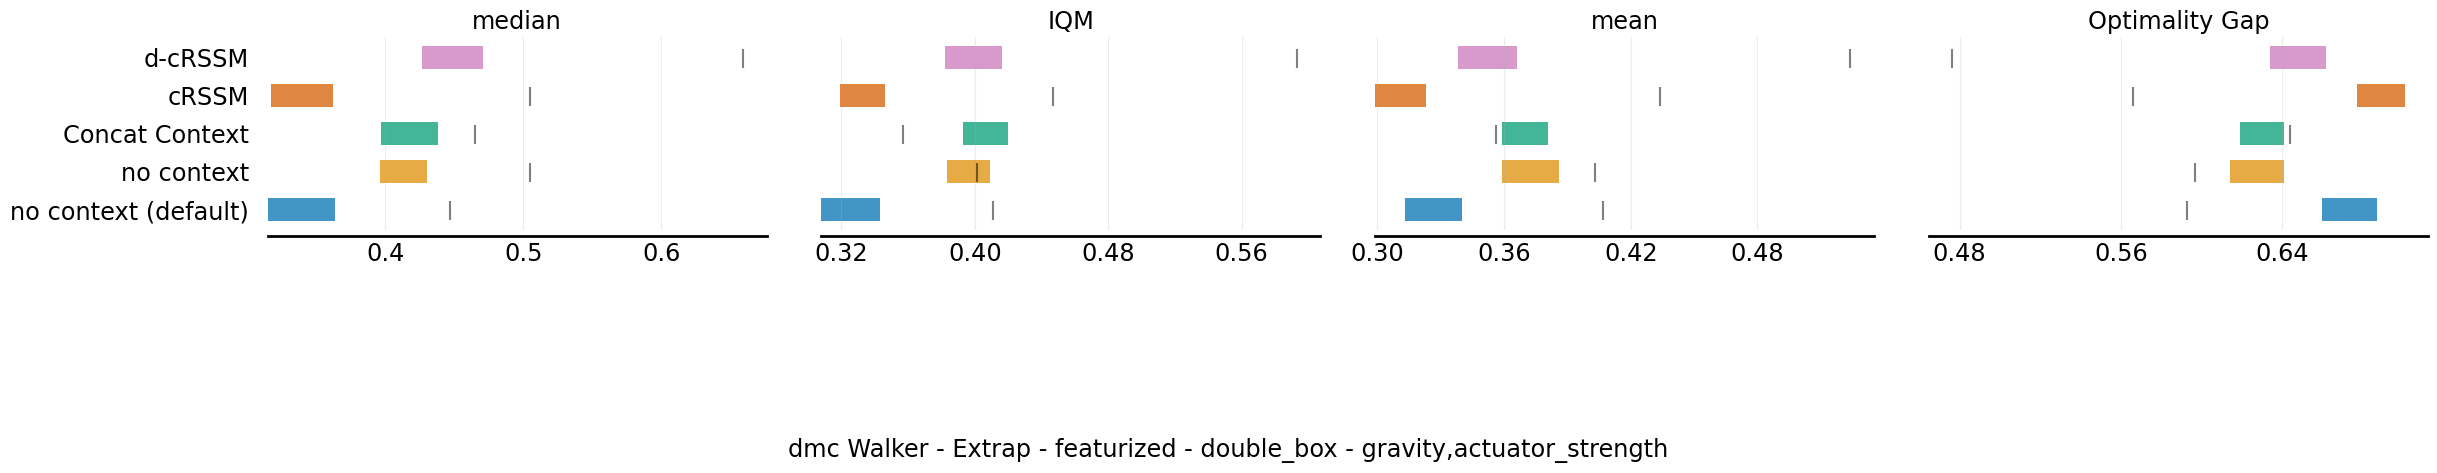

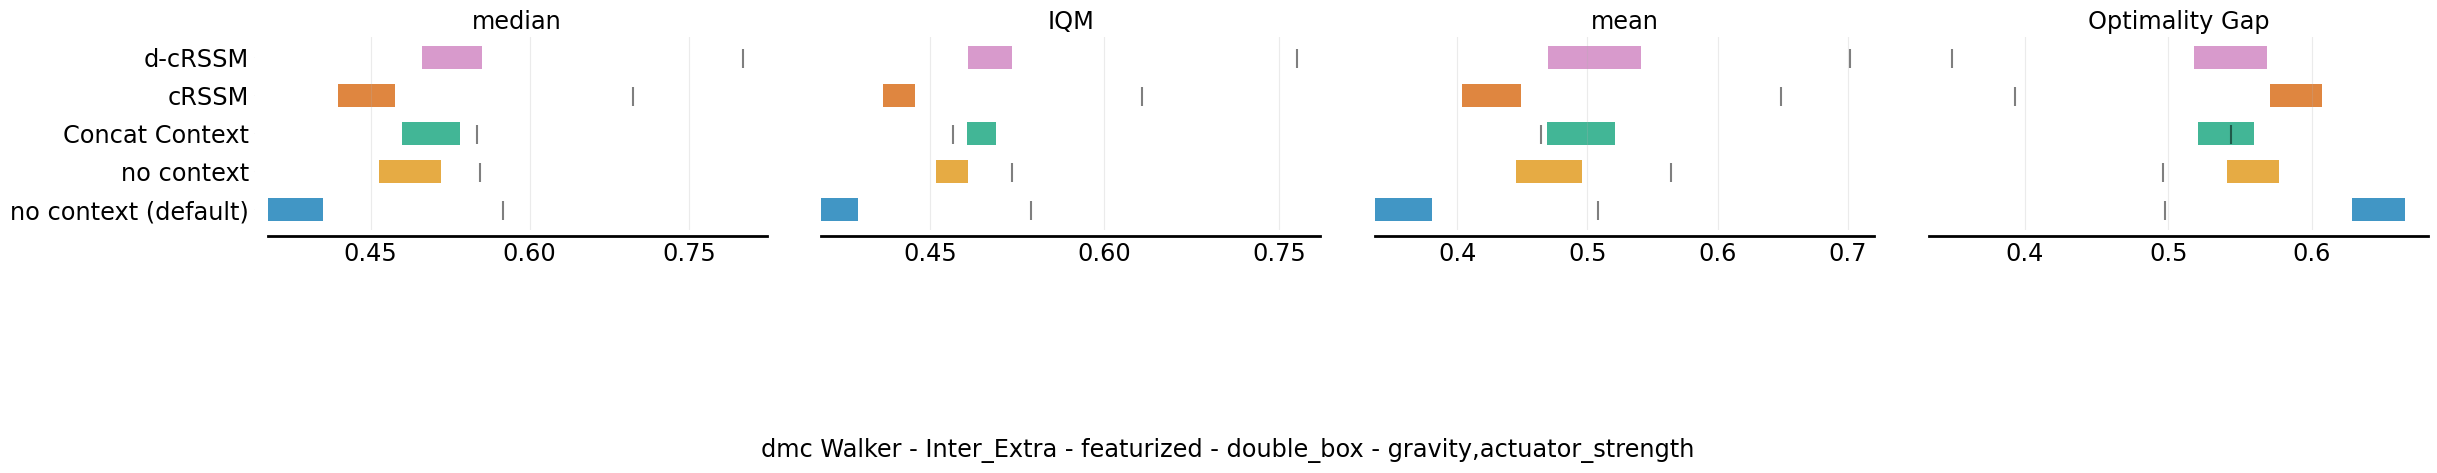

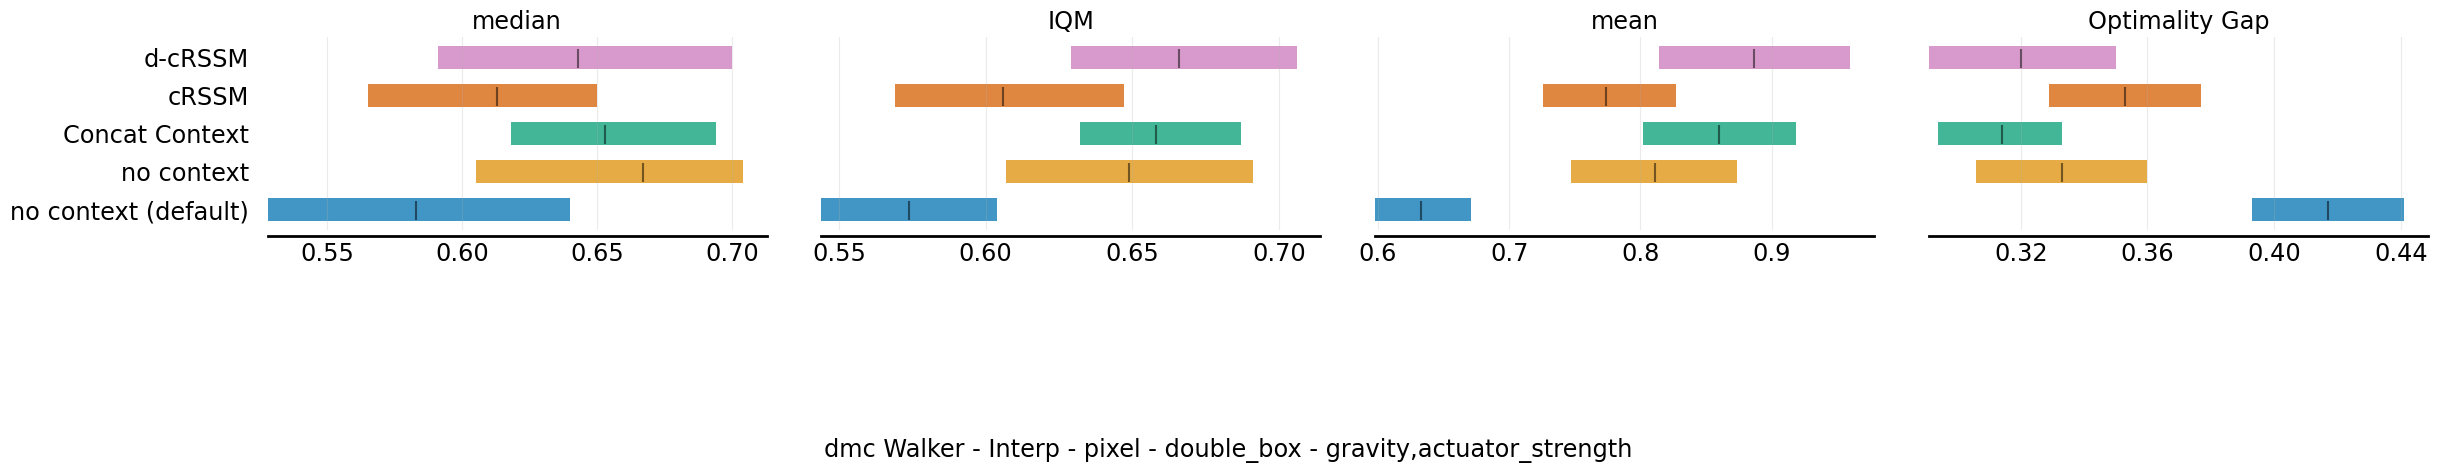

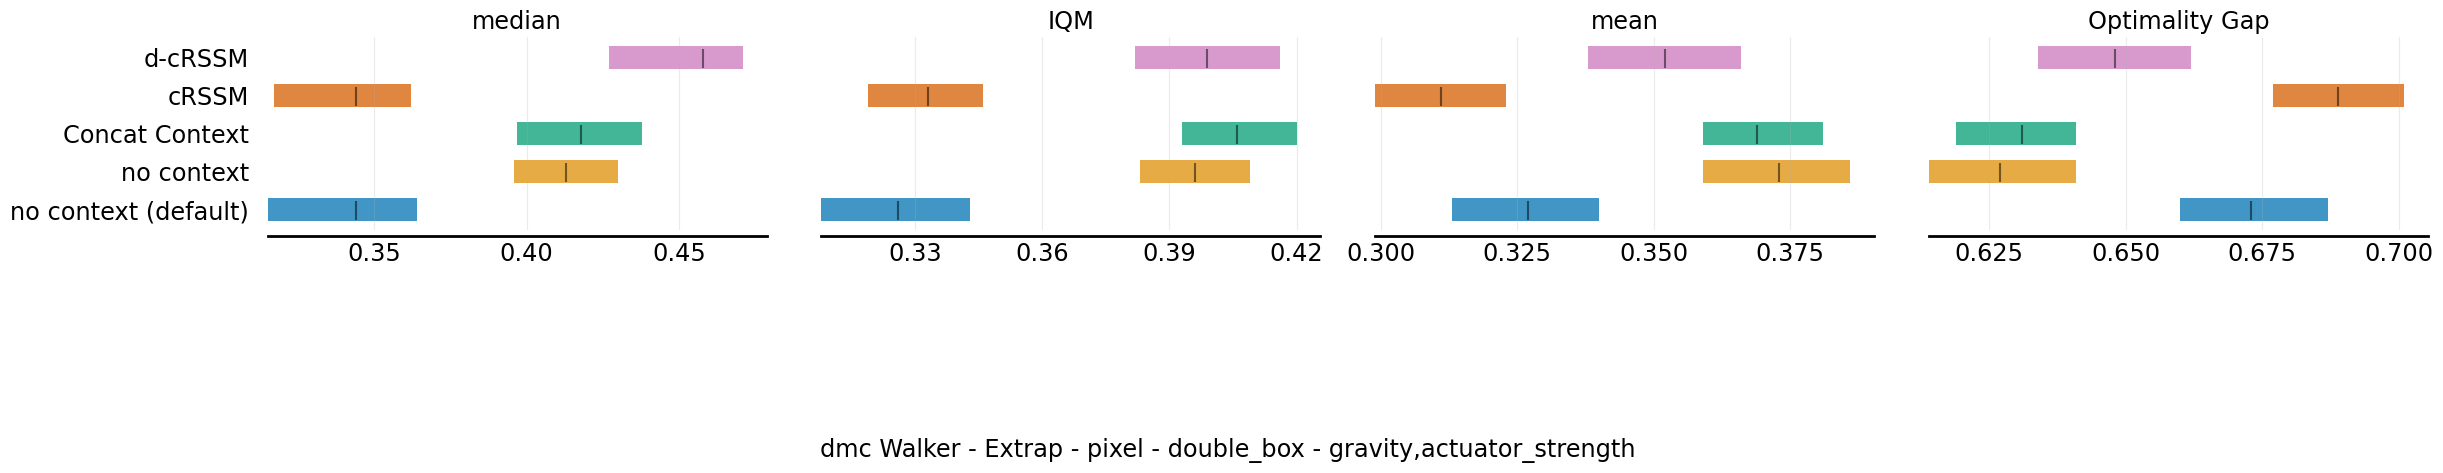

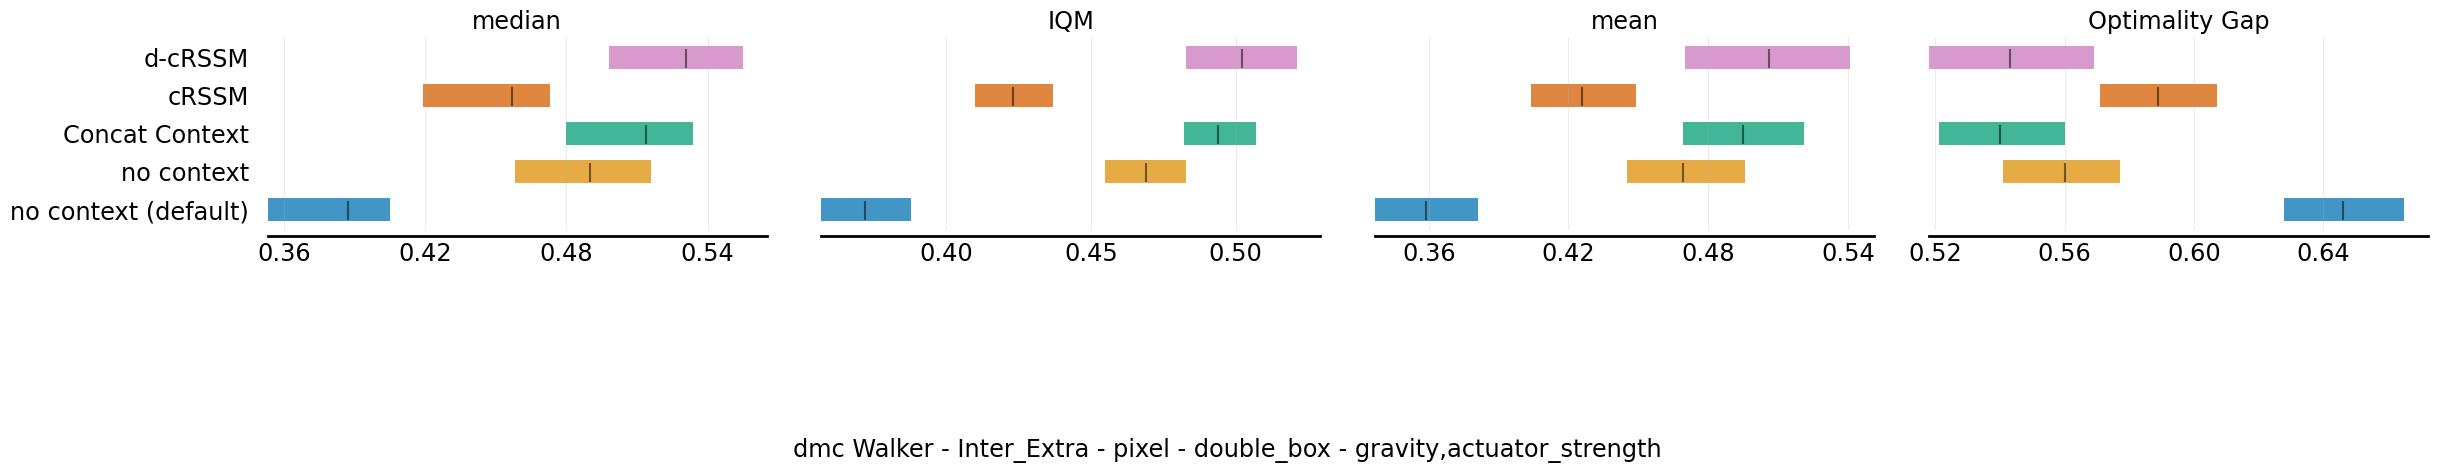

In [27]:
# loop for each five rows and use plot compare_plot_algorithms for each
for name, subframe in df.groupby(np.arange(len(df)) // 5):
    #print(name)
    #print(group.head())
    compare_plot_algorithms(subframe)